In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy import integrate
import matplotlib.cm as cm
import scipy
import sncosmo
from itertools import cycle


import astropy.units as u
%matplotlib inline

In [2]:
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

In [3]:
import astropy
mycosmo = astropy.cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [4]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/data/"
FILTER_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Sullivan_Filters/"

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq','SN2006aa']
#OUTPUT
# - fitted_photometry
#  for each object (1) Table with fitted photometry @spctra MJD
#                  (2) high cadence fitted photometry 
#                  (3) plot of the fit in each band

color_dict = {'A':'grey',
              'BessellU': 'blue',
              'BessellB': 'royalblue',
                'BessellV':  'limegreen',
                'BessellR':  'red',
                'BessellI':  'mediumvioletred',
                'SDSS_g':    'darkgreen',
                'SDSS_i':    'purple',
                'SDSS_r':    'darkred',
                'SDSS_z':    'sienna',
                'SDSS_u': 'darkblue',
                'swift_UVW1':'grey',
                'swift_UVW2':'grey',
                'swift_UVM2':'grey',
                'swift_U':'grey',
                'swift_V':'grey',
                'swift_B':'grey'}


color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'mediumvioletred',
                'sdss_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'darkred', "sdss_r'":    'darkred',
                'sdss_z':    'sienna', "sdss_z'":    'sienna',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue'}

In [5]:
import astropy
mycosmo = astropy.cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [6]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux



In [7]:
def calc_lam_eff(wls, transmission, flux):
    return (integrate.trapz(transmission*flux*wls, wls)/\
            integrate.trapz(transmission*flux, wls))


def prop_err_div(x,y,sig_x,sig_y):
    return ((sig_x/y)**2  +  ((x*sig_y)/y**2)**2 )**0.5

In [8]:
convert2mjd = (lambda x: float(x.replace('_spec_extended.txt','').replace('_spec_extended_FL.txt','').replace('_spec_extended_SMOOTH.txt','')))

In [101]:
class ReMangle_SingleSpectrumClass():
    """Class to load and mangle a single spectrum:
    """
    
    def __init__(self, main_path, snname, twodim=True, spec_file=None, verbose=False):
        """
        """
        ## Initialise the class variables            
        self.main_path = main_path
        self.lc_data_path = main_path+'lc/'
        self.fitted_data_path = main_path+'lc/'
        self.spec_data_path = main_path+'spec/'
        self.snname = snname
        self.check_results_folder()
        self.extension_type='2dim' if twodim else 'classic'
        self.create_FINALspec_folder()
        
        if spec_file is None:
            print ("Choose one spec_file from this list:")
            print (self.get_spec_list())
        else:
            self.spec_file = spec_file
            print ('self.spec_file', self.spec_file)
            self.load_manglingfile()
        self.load_final_info()

    def check_results_folder(self):
        results_directory = self.main_path+'/results_template/%s/'%self.snname
        if not os.path.exists(results_directory):
            print ("I cant mangle a spectrum if I theres no fitted LC yet")
        else: self.results_mainpath = results_directory

    def check_extended_file(self):
        if self.extension_type == '2dim':
            mangled_file_path = self.main_path+'/results_template/%s/TwoDextended_spectra/%s'%(self.snname,\
                                                                                      self.spec_file)
        else:
            mangled_file_path = self.main_path+'/results_template/%s/extended_spectra/%s'%(self.snname,\
                                                                                      self.spec_file)
        if not os.path.isfile(mangled_file_path):
            print ("Sorry, This object %s has not mangled file"%mangled_file_path)
        else: 
            self.mangled_file_path = mangled_file_path

    def get_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended.txt' in f]
        return onlyfiles

    def check_spec_manglingphot(self):
        all_specs = self.get_spec_list()
        mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
        phot4mangling = pd.read_csv(mangling_file, sep='\t')
        for spec_file in all_specs:
            file_mjd = float(spec_file.replace('_spec_extended.txt',''))
            mask = phot4mangling['spec_mjd'].values == file_mjd
            if len(phot4mangling[mask])==0:
                print ('There.s no magnling photometry fro this. Are you sure nothing went wrong?', spec_file)
                print ('I compared', phot4mangling['spec_mjd'].values ,file_mjd)

    def get_FLAGGED_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_FL.txt' in f]
        return onlyfiles

    def get_SMOOTH_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_SMOOTH.txt' in f]
        return onlyfiles


    def get_SNF_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_SNF.txt' in f]
        return onlyfiles

    
    def load_original_phot(self, verbose = False):
        SNphotometry_PATH = os.path.join(self.main_path+\
                                         '/results_template/%s/fitted_phot_%s.dat'%(self.snname,self.snname))
        #lc_file = np.genfromtxt(SNphotometry_PATH, names=True, dtype=None,encoding="utf-8")
        lc_pd = pd.read_csv(SNphotometry_PATH, sep='\t')
        self.original_phot = lc_pd
        return lc_pd
    
    def load_manglingfile(self):
        if not hasattr(self, "results_mainpath"):
            self.check_results_folder()
        else:
            if (not 'FL.txt' in self.spec_file)&(not 'SNF.txt' in self.spec_file)&(not 'SMOOTH.txt' in self.spec_file):
                mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
                phot4mangling = pd.read_csv(mangling_file, sep='\t')
                file_mjd = convert2mjd(self.spec_file)
                mask = phot4mangling['spec_mjd'].values == file_mjd
                self.phot4mangling = (phot4mangling[mask])
                if len(self.phot4mangling)<1:
                    raise Exception(""" ### ERROR: 
                    I looked in the file with the PHOTOMETRY for MANGLING 
                    (i.e. fitted_phot4mangling_SNNAME.dat).
                    I was loading the photometry to mangle/extend the spectrum you are currently loading
                    in the GRID. I found NO photometry for it... Maybe you should re run GP fit or check your list of spec.""")

                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
                
            elif 'SNF.txt' in self.spec_file: 
                phot4mangling = self.load_original_phot()
                file_mjd = float(self.spec_file.replace('_spec_extended_SNF.txt',''))
                
                mask = phot4mangling.index == np.argmin(np.abs(phot4mangling['MJD'].values - file_mjd))
                new_columns =[]
                for c in phot4mangling.columns:
                    if ('_err' not in c)&('MJD' not in c): new_columns.append(c+'_fitflux')
                    elif ('_err' in c): new_columns.append(c.replace('_err','')+'_fitfluxerr')
                    elif ('MJD' in c): new_columns.append('spec_mjd')
                phot4mangling.columns = new_columns 
                self.phot4mangling = phot4mangling[mask]
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
            else: 
                phot4mangling = self.load_original_phot()
                file_mjd = convert2mjd(self.spec_file)
                mask = phot4mangling.index == np.argmin(np.abs(phot4mangling['MJD'].values - file_mjd))
                new_columns =[]
                for c in phot4mangling.columns:
                    if ('_err' not in c)&('MJD' not in c): new_columns.append(c+'_fitflux')
                    elif ('_err' in c): new_columns.append(c.replace('_err','')+'_fitfluxerr')
                    elif ('MJD' in c): new_columns.append('spec_mjd')
                phot4mangling.columns = new_columns 
                self.phot4mangling = phot4mangling[mask]
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']

    def load_extended_spec(self):
        if not hasattr(self, 'extended_files_path'):
            lista = self.get_spec_list()
        ext_spec = np.genfromtxt(self.extended_files_path+self.spec_file,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'fluxerr'])
        self.ext_spec = ext_spec
        return ext_spec
  
    def create_mangledspec_folder(self):
        mangledspec_directory = self.main_path+'/results_template/%s/RE_mangled_spectra_%s/'%(self.snname, self.extension_type)
        if not os.path.exists(mangledspec_directory):
            os.makedirs(mangledspec_directory)
        self.mangledspec_path = mangledspec_directory
   
    def create_FINALspec_folder(self):
        FINAL_directory = self.main_path+'/results_template/%s/FINAL_spectra_%s/'%(self.snname, self.extension_type)
        if not os.path.exists(FINAL_directory):
            os.makedirs(FINAL_directory)
        if not os.path.exists(FINAL_directory+'/HostNotCorr/'):
            os.makedirs(FINAL_directory+'/HostNotCorr/')
        if not os.path.exists(FINAL_directory+'/as_observed/'):
            os.makedirs(FINAL_directory+'/as_observed/')
            
        self.FINALspec_path = FINAL_directory

    def calculate_ratios4mangling(self, use_what_4phot=None):
        ratios=[]
        ratios_err=[]
        fitted_phot_list=[]
        fitted_photerr_list=[]
        wls_eff=[]
        used_filters=[]
        
        outMJD_ratios=[]
        outMJD_ratios_err=[]
        outMJD_fitted_phot_list=[]
        outMJD_fitted_photerr_list=[]
        outMJD_wls_eff=[]
        outMJD_used_filters=[]
        for filt in self.avail_filters:
            fitted_phot = self.phot4mangling['%s_fitflux'%filt].values[0]
            fitted_phot_err = self.phot4mangling['%s_fitfluxerr'%filt].values[0]
            
            if '%s_inrange'%filt in self.phot4mangling.columns: 
                inMJDrange_pnt = self.phot4mangling['%s_inrange'%filt].values[0]
            else: # this means the spectrum is synthesized from the 2dim surface
                inMJDrange_pnt = ~np.isnan(fitted_phot)

            lam_eff, raw_phot, raw_phot_err = self.band_flux(filt, use_what = use_what_4phot)

            if (not inMJDrange_pnt):
                outMJD_fitted_phot_list.append(fitted_phot)
                outMJD_fitted_photerr_list.append(fitted_phot_err)
                outMJD_ratios.append(fitted_phot/raw_phot)
                #outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, raw_phot_err) )
                outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, 0.) )
                outMJD_wls_eff.append(lam_eff)
                outMJD_used_filters.append(filt)
            else:
                fitted_phot_list.append(fitted_phot)
                fitted_photerr_list.append(fitted_phot_err)
                ratios.append(fitted_phot/raw_phot)
                #ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, raw_phot_err) )
                ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err , 0.) )
                wls_eff.append(lam_eff)
                used_filters.append(filt)
        #print ('ratios',len(ratios))
        ratios = np.array(ratios)
        wls_eff = np.array(wls_eff)
        ratios_err = np.array(ratios_err)
        used_filters = np.array(used_filters)
        outMJD_wls_eff = np.array(outMJD_wls_eff)
        outMJD_used_filters = np.array(outMJD_used_filters)

        
        self.fitted_phot_dict = {'eff_wls':wls_eff, 'fitted_phot':fitted_phot_list,\
                                     'fitted_phot_err':fitted_photerr_list, 'used_filters': used_filters}

        return ratios, ratios_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters

    def GP_interpolation_mangle(self, wls_eff, ratios, ratios_err, min_scale, optimization=True):
        if len(self.ext_spec['wls'])>10**4:
            # GP struggle to handle such a big number of points
            int_fraction = int(len(self.ext_spec['wls'])/5000.)
            print ('This spectrum has a huge amount of data points(%i), Im chopping a %i th of them'%(len(self.ext_spec['wls']), int_fraction))
            full_wls = self.ext_spec['wls'][::int_fraction]
        else:
            full_wls = self.ext_spec['wls']
        
        norm_wls = np.median(full_wls)
        full_wls_normed = full_wls/norm_wls
        wls_eff_normed = np.array(wls_eff)/norm_wls
            
        offset=1.
        norm = np.mean(ratios)
        ratios_normed = np.array(ratios)/norm-offset
        ratios_err_normed = np.array(ratios_err)/norm
        
        if len(ratios_normed)<1:
            return np.ones(len(full_wls_normed))*np.nan, np.ones(len(full_wls_normed))*np.nan
        else:
            def ll(p):
                #print (np.exp(p))
                if (np.exp(p)[1]<5*10**-3):#|(np.exp(p)[1]>10**5):
                    return np.inf
                else:
                    gp.set_parameter_vector(p)
                    return -gp.lnlikelihood(ratios_normed, quiet=False)#
            def grad_ll(p):
                gp.set_parameter_vector(p)
                return -gp.grad_lnlikelihood(ratios_normed, quiet=False)
            k= np.var(ratios_normed)*Matern32Kernel(0.3)
            wls_eff_normedT = np.atleast_2d(wls_eff_normed).T
            gp = george.GP(k)
            gp.compute(wls_eff_normedT, (ratios_err_normed))
            if optimization:
                try:
                    p0=gp.get_parameter_vector()
                    results = opt.minimize(ll, p0, jac=grad_ll)
                    print ('SCALE:',  '%.4f'%np.exp(results.x[1]))
                except:
                    pass
                    print ('*** GP optimization failed ***'*10)
            #print ('results', np.exp(results.x))
            mu, cov = gp.predict(ratios_normed, full_wls_normed)
            std = np.sqrt(np.diag(cov))
                
            if len(self.ext_spec['wls'])>10**4:
                # GP struggle to handle such a big number of points
                mu_full = np.interp(self.ext_spec['wls'], self.ext_spec['wls'][::int_fraction], mu)
                std_full = np.interp(self.ext_spec['wls'], self.ext_spec['wls'][::int_fraction], std)
            else:
                mu_full = mu
                std_full = std
            return norm*(mu_full+offset), np.abs(norm*(std_full))


    def band_flux(self, filter_name, use_what='ext_spectrum'):
        if use_what == 'ext_spectrum':
            spec_flux = self.ext_spec
            #print ('Im using the UNmangled one')
        else:
            spec_flux = self.mangled_spec[use_what]
            #print ('Im using the %s-TIME mangled one'%use_what)

        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])

        cut_spec = [(spec_flux['wls']>min(filt_transm['wls']))&\
                     (spec_flux['wls']<max(filt_transm['wls']))]
        cut_ext_spec = spec_flux[cut_spec].copy()
        
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], 
                                                       filt_transm['flux'], 
                                                       kind='linear')
        filt_transm_interp = filt_transm_interp_func(cut_ext_spec['wls'])
        filt_transm_interp_xLambda = filt_transm_interp*cut_ext_spec['wls']
        
        lam_eff = calc_lam_eff(cut_ext_spec['wls'], 
                                        filt_transm_interp, 
                                        cut_ext_spec['flux']) 

        raw_phot = integrate.trapz(filt_transm_interp_xLambda*cut_ext_spec['flux'], cut_ext_spec['wls'])/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_ext_spec['wls'])
            
        raw_phot_err = (integrate.trapz((filt_transm_interp_xLambda*cut_ext_spec['fluxerr'])**2, 
                                        cut_ext_spec['wls']))**0.5/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_ext_spec['wls'])
        if use_what == 'ext_spectrum': 
            return lam_eff, raw_phot, raw_phot_err
        else: 
            return lam_eff, raw_phot, raw_phot_err

    def mangle_iteration_function(self):
        if ('FL' in self.spec_file):
            min_scale=0.5
            optimization=False
        else:
            min_scale=0.5#min_scale=5*10**-3
            optimization=False#optimization=True
        
        # 1st iteration        
        ratios_0, ratios_0_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters =\
            self.calculate_ratios4mangling(use_what_4phot='ext_spectrum')
        mang_mask, mang_mask_err = self.GP_interpolation_mangle(wls_eff, ratios_0, 
                                                                ratios_0_err, min_scale, 
                                                                optimization=optimization)

        mangled_spec = self.ext_spec['flux'] * mang_mask
        mangled_spec_err = ((self.ext_spec['flux'] * mang_mask_err)**2)**0.5

        self.mangled_spec = {0 : np.array([a for a in zip(self.ext_spec['wls'],
                                                            mangled_spec, mangled_spec_err)],
                                     dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])}
        self.mangling_mask = {0 : (mang_mask, mang_mask_err) }
        
        mangled_phot_list=[]
        for filt in used_filters:
            mangled_phot_list.append(self.band_flux(filt, use_what=0)[1])
        self.magled_photometry_dict = {0 : {'eff_wls': wls_eff, 
                                              'fitted_phot': mangled_phot_list,\
                                           'used_filters': used_filters}}

        # More iterations
        ratios = ratios_0
        max_iteration = 5
        for i in range(max_iteration):
            if max(np.abs(ratios-1.))>0.01:
                #print (i)
                ratios_iter, ratios_iter_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters =\
                    self.calculate_ratios4mangling(use_what_4phot=(i))
                mang_mask, mang_mask_err = self.GP_interpolation_mangle(wls_eff, ratios_iter, 
                                                                            ratios_iter_err, min_scale, 
                                                                        optimization=optimization)
                #print ('iteration', i,ratios_iter)
                mangled_spec = self.mangled_spec[i]['flux'] * mang_mask
                #mangled_spec_err = ( (self.mangled_spec[str(i+1)]['flux'] * mang_mask_err)**2 +\
                #            (self.mangled_spec[str(i+1)]['fluxerr'] * mang_mask)**2 )**0.5
                mangled_spec_err = (self.mangled_spec[i]['flux'] * mang_mask_err)

                #print ('save new', (i+1))
                self.mangled_spec[i+1] = np.array([a for a in zip(self.ext_spec['wls'], 
                                                                       mangled_spec, mangled_spec_err)],
                                         dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])
                
                self.mangling_mask[i+1] = (mang_mask, mang_mask_err)
                mangled_phot_list=[]
                for filt in used_filters:
                    mangled_phot_list.append(self.band_flux(filt, use_what=i+1)[1])
                self.magled_photometry_dict[i+1] = {'eff_wls': wls_eff, 'fitted_phot': mangled_phot_list,\
                                                       'used_filters': used_filters}
                ratios = np.copy(ratios_iter)
            else:
                pass
        self.mangling_mask_FINAL = mangled_spec/self.ext_spec['flux']
        iters_list = list(self.mangled_spec.keys())
        last_iter = iters_list[-1]
        #print ('last_iter', last_iter)
        self.final_mangled_spec = self.mangled_spec[last_iter]
        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]

        fig=plt.figure(1, figsize=(10,6))
        ax1 = plt.subplot2grid((3,1), (0,0))
        for f,w,r,rerr in zip(used_filters, wls_eff,\
                              ratios_0, ratios_0_err):
            ax1.errorbar(w, r, yerr=rerr, marker='o', mfc= color_dict[f], mec=color_dict[f], linestyle='None',\
                     ecolor= color_dict[f], label='%s'%f)
        #print (iters_list)
        for it in (iters_list):
            mask, mask_err = self.mangling_mask[it]
            ax1.errorbar(self.ext_spec['wls'], mask, color='orange', lw=0.3, alpha=0.5)
            ax1.fill_between(self.ext_spec['wls'], mask-mask_err, mask+mask_err, 
                             color='orange',alpha=0.3)
        ax1.errorbar(self.ext_spec['wls'], self.mangling_mask_FINAL, 
                     color='red', linestyle=':', lw=1.5, alpha=0.9)
        ax1.fill_between(self.ext_spec['wls'], self.mangling_mask_FINAL-mask_err, self.mangling_mask_FINAL+mask_err,
                     facecolor='red', alpha=0.5)

        ax1.set_ylabel('Phot from LCfitting /\n Phot from Raw Spec')
        ax1.set_xlabel('Effective Wavelenght')
        ax1.set_title('%s: Mangled spectrum %s'%(self.snname, self.spec_file))
        ax1.set_xlim(1600., 10500.)
        ax1.legend(ncol=5, fontsize=6)
        
        ax2 = plt.subplot2grid((3,1), (1,0), rowspan=2)
        if ('FL' in self.spec_file)|('SNF' in self.spec_file):
            ax2.errorbar(self.mangled_spec[last_iter]['wls'], self.mangled_spec[last_iter]['flux'],\
                     lw=0.7, color='k', linestyle='--', label='Mangled_Spec FAKE SPEC')
        else:
            ax2.errorbar(self.mangled_spec[last_iter]['wls'], self.mangled_spec[last_iter]['flux'],\
                     lw=0.7, color='k', label='Mangled_Spec')

        ax2.errorbar(self.ext_spec['wls'], self.ext_spec['flux'],\
                     lw=0.7, color='r', label='Raw Spec')
        ax2.errorbar(self.fitted_phot_dict['eff_wls'], self.fitted_phot_dict['fitted_phot'],\
                     yerr=self.fitted_phot_dict['fitted_phot_err'], marker='o',
                     linestyle='None', label='Fitted Phot')
        ax2.errorbar(self.magled_photometry_dict[last_iter]['eff_wls'],
                     self.magled_photometry_dict[last_iter]['fitted_phot'],\
                     marker='^', mfc='r', mec='r', linestyle='None', label='Phot from mangled spec')
        ax2.plot(self.magled_photometry_dict[iters_list[-1]]['eff_wls'], 
                 self.magled_photometry_dict[iters_list[-1]]['fitted_phot'],\
                 marker='.', mfc='r', mec = 'None', linestyle='None')
        print ('ITERATION', last_iter, iters_list[-1])
        ax2.fill_between(self.mangled_spec[last_iter]['wls'], 
                         self.mangled_spec[last_iter]['flux']-self.mangled_spec[last_iter]['fluxerr'],\
                         self.mangled_spec[last_iter]['flux']+self.mangled_spec[last_iter]['fluxerr'], 
                         color='grey',alpha=0.3)
        ax2.set_ylabel('Flux erg s-1 cm-2 A-1')
        ax2.set_xlabel('Wavelenght')
        ax2.set_xlim(1600., 10500.)
        ax2.legend()
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        if 'FL' in self.spec_file:
            fig.savefig(self.mangledspec_path+self.spec_file.replace('_spec_extended_FL.txt','_REmangled_spec_FL.png'),
                        bbox_inches='tight')
        elif 'SNF' in self.spec_file:
            fig.savefig(self.mangledspec_path+self.spec_file.replace('_spec_extended_SNF.txt','_REmangled_spec_SNF.pdf'),
                        bbox_inches='tight')
        else:
            fig.savefig(self.mangledspec_path+'%.2f_REmangled_spec.png'%spec_number, bbox_inches='tight')

        plt.close(fig)
        
        self.save_mangled_spectrum()
        return list(self.mangled_spec.keys())

        
    def get_diff_FittedMangled_phot(self):
        fitted_phot = np.array(self.fitted_phot_dict['fitted_phot'])
        fitted_phot_err = np.array(self.fitted_phot_dict['fitted_phot_err'])
        mangled_phot = np.array(self.magled_photometry_dict['fitted_phot'])
        diff_mag = -2.5*np.log10(mangled_phot/fitted_phot)
        
        def err_fromFlux_toMag(flux, err_flux):
            flux = np.array(flux, dtype=float)
            err_flux = np.array(err_flux, dtype=float)
            return 2.5/np.log(10.) * err_flux/flux
    
        fitted_phot_err_mag = err_fromFlux_toMag(fitted_phot, fitted_phot_err)
        discrepancy_mag = diff_mag/fitted_phot_err_mag
        return self.magled_photometry_dict['used_filters'], diff_mag, discrepancy_mag 

    def get_filter_transmission(self, f):
        filt_transm = np.genfromtxt(self.main_path+'filters/%s.dat'%f,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        return filt_transm

    def save_mangled_spectrum(self):

        if (not hasattr(self, 'final_mangled_spec')):
            print ("Mangled spectrum not available. First you have to mangle the spectrum calling self.mangle_spectrum()")
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        
        save_path = self.mangledspec_path

        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        if 'FL' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_FL.txt','_REmangled_spec_FL.txt'), 'w')
        elif 'SMOOTH' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_SMOOTH.txt','_REmangled_spec_SMOOTH.txt'), 'w')
        elif 'SNF' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_SNF.txt','_REmangled_spec_SNF.txt'), 'w')
        else:
            fout = open(self.mangledspec_path+'/%.2f_REmangled_spec.txt'%spec_number, 'w')

        fout.write('#wls\tflux\tfluxerr\n')
        for w,f,ferr in zip(self.ext_spec['wls'], self.final_mangled_spec['flux'], self.final_mangled_spec['fluxerr']):
            fout.write('%E\t%E\t%E\n'%(w,f,ferr))
        fout.close() 
        
        
    def load_final_info(self):
        final_info_table = pd.read_csv(self.main_path+'/info/FINAL_info.dat')
        mask = final_info_table.Name==self.snname
        if len(final_info_table[mask])==0:
            raise Exception((' !!!!!!!!!!!!! \n I CANT FIND THIS OBJECT IN THE FINAL_info.dat FILE!! \n Add it to the PYCOCO/info/FINAL_info.dat first.'))
        return (final_info_table[mask])
        
        
    def save_FINAL_spectrum(self):
        if (not hasattr(self, 'final_mangled_spec')):
            print ("Mangled spectrum not available. First you need to mangle the spectrum calling self.mangle_spectrum()")
        if (not hasattr(self, 'FINALspec_path')):
            self.create_FINALspec_folder()

        flux = self.final_mangled_spec['flux']
        fluxerr = self.final_mangled_spec['fluxerr']
        
        sn_info = self.load_final_info()
        MWdust = sncosmo.CCM89Dust()
        Hostdust = sncosmo.CCM89Dust()
        r_v = 3.1
        z = sn_info['z'].values[0]
        
        wls = self.ext_spec['wls']
        wls_restframe = self.ext_spec['wls']/(1+z)
        
        # MW corrections in SN restframe
        MW_ebv = sn_info['MW ebv'].values[0]
        MWdust.parameters = [MW_ebv, r_v]
        MW_extinction_perc = MWdust.propagate(wls_restframe, np.ones(len(flux)))
        
        # Host corrections in SN restframe
        Host_ebv = sn_info['Host ebv'].values[0]
        if 'ddag' in Host_ebv: Host_ebv = float(Host_ebv.replace('ddag','')) 
        Hostdust.parameters = [Host_ebv, r_v]
        Host_extinction_perc = Hostdust.propagate(wls, np.ones(len(flux)))

        dist = 10**(mycosmo.distmod(z).value/5.+1)
        To_abs_lum = (dist/10.)**2

        self.final_spec_wls = wls_restframe
        self.HostCorr_spec_flux = To_abs_lum*flux
        self.HostCorr_spec_fluxerr = To_abs_lum*fluxerr

        self.HostNOTCorr_spec_flux = To_abs_lum*flux*Host_extinction_perc
        self.HostNOTCorr_spec_fluxerr = To_abs_lum*fluxerr*Host_extinction_perc
        
        self.as_observed_spec_flux = flux*Host_extinction_perc*MW_extinction_perc
        self.as_observed_spec_fluxerr = fluxerr*Host_extinction_perc*MW_extinction_perc

        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        
        
        for path_fold in ['', '/HostNotCorr/','/as_observed/']:
            path = self.FINALspec_path + path_fold
            if 'FL' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_FL.txt','_FINAL_spec_FL.txt'), 'w')
            elif 'SMOOTH' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_SMOOTH.txt','_FINAL_spec_SMOOTH.txt'), 'w')
            elif 'SNF' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_SNF.txt','_FINAL_spec_SNF.txt'), 'w')
            else:
                fout = open(path+'/%.2f_FINAL_spec.txt'%spec_number, 'w')
            fout.write('#wls\tflux\tfluxerr\n')
            if path_fold=='':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.HostCorr_spec_flux, 
                                self.HostCorr_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 
            elif path_fold=='/HostNotCorr/':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.HostNOTCorr_spec_flux, 
                                self.HostNOTCorr_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 
            
            elif path_fold=='/as_observed/':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.as_observed_spec_flux, 
                                self.as_observed_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 

        #if self.snname in Alternative_RV_dict.keys():
        #    different_r_v = 3.1
        #    Host_ebv  = 0.0        
#
#            Hostdust.parameters = [Host_ebv, different_r_v]
#            Host_extinction_perc = Hostdust.propagate(wls, np.ones(len(flux)))
#
#            self.HostNOTCorr_spec_flux = To_abs_lum*flux*Host_extinction_perc
#            self.HostNOTCorr_spec_fluxerr = To_abs_lum*fluxerr*Host_extinction_perc
#

In [102]:
SN_lista_II = ['SN2013by','SN2014G','ASASSN15oz','SN2007od','SN2013ej','SN2013fs','SN2008bj',
'SN2016X','SN2013ab','SN2009bw','SN2012aw','SN2008in','SN2004et','SN2009dd',
'SN1999em','SN2009kr','ASASSN14jb','SN2012A','SN2009ib','SN2013am','SN2016bkv','SN2009N',
'SN2005cs', 'SN2008fq', 'SN2007pk', 'SN2010al', 'SN2009ip', 'SN2006aa', 'SN2011ht','SN2013bynouv']

SN_lista_Ib = ['SN1993J', 'SN2006T', 'SN2008aq', 'SN2008ax', 'SN2008bo', 'SN2011dh', 'SN2011ei', 
               'SN2011fu', 'SN2011hs', 'SN2013df','SN2016gkg', 'SN1999dn', 'SN2004gq', 'SN2004gv', 'SN2005bf',
               'SN2005hg', 'SN2006ep',  'SN2007Y', 'SN2007uy',  'SN2008D', 'SN2009iz',
               'SN2009jf', 'SN2012au','iPTF13bvn', 'SN1994I','SN2004aw','SN2004fe',
               'SN2004gt','SN2007gr','SN2011bm','SN2013ge','SN1998bw','SN2002ap','SN2006aj',
               'SN2007ru','SN2009bb', 'SN2012ap']

sn_type_lista = [('ASASSN14jb', 'II'),
 ('ASASSN15oz', 'II'),
 ('SN1993J', 'IIb'),
 ('SN1994I', 'Ic'),
 ('SN1998bw', 'Ic-BL'),
 ('SN1999dn', 'Ib'),
 ('SN1999em', 'II'),
 ('SN2002ap', 'Ic-BL'),
 ('SN2004aw', 'Ic'),
 ('SN2004et', 'II'),
 ('SN2004fe', 'Ic'),
 ('SN2004gq', 'Ib'),
 ('SN2004gt', 'Ic'),
 ('SN2004gv', 'Ib'),
 ('SN2005bf', 'Ib'),
 ('SN2005cs', 'II'),
 ('SN2005hg', 'Ib'),
 ('SN2006T', 'IIb'),
 ('SN2006aa', 'IIn'),
 ('SN2006aj', 'Ic-BL'),
 ('SN2006ep', 'Ib'),
 ('SN2007Y', 'Ib'),
 ('SN2007gr', 'Ic'),
 ('SN2007od', 'II'),
 ('SN2007pk', 'IIn'),
 ('SN2007ru', 'Ic-BL'),
 ('SN2007uy', 'Ib'),
 ('SN2008D', 'Ib'),
 ('SN2008aq', 'IIb'),
 ('SN2008ax', 'IIb'),
 ('SN2008bj', 'II'),
 ('SN2008bo', 'IIb'),
 ('SN2008fq', 'IIn'),
 ('SN2008in', 'II'),
 ('SN2009N', 'II'),
 ('SN2009bb', 'Ic-BL'),
 ('SN2009bw', 'II'),
 ('SN2009dd', 'II'),
 ('SN2009ib', 'II'),
 ('SN2009ip', 'IIn'),
 ('SN2009iz', 'Ib'),
 ('SN2009jf', 'Ib'),
 ('SN2009kr', 'II'),
 ('SN2010al', 'IIn'),
 ('SN2011bm', 'Ic'),
 ('SN2011dh', 'IIb'),
 ('SN2011ei', 'IIb'),
 ('SN2011fu', 'IIb'),
 ('SN2011hs', 'IIb'),
 ('SN2011ht', 'IIn'),
 ('SN2012A', 'II'),
 ('SN2012ap', 'Ic-BL'),
 ('SN2012au', 'Ib'),
 ('SN2012aw', 'II'),
 ('SN2013ab', 'II'),
 ('SN2013am', 'II'),
 ('SN2013by', 'II'),
 ('SN2013df', 'IIb'),
 ('SN2013ej', 'II'),
 ('SN2013fs', 'II'),
 ('SN2013ge', 'Ic'),
 ('SN2014G', 'II'),
 ('SN2016X', 'II'),
 ('SN2016bkv', 'II'),
 ('SN2016gkg', 'IIb'),
 ('iPTF13bvn', 'Ib'),
 ('SN2013bynouv', 'II')]

In [103]:
SN_lista=['SN2016X', 'SN2013am', 'SN2009N', 'SN2009kr','SN1999em', 'SN2013df']

In [18]:
 for snname,type_ in sn_type_lista:
    if snname in SN_lista:
        mangledspec_directory = DATALC_PATH+'/results_template/%s/RE_mangled_spectra_%s/'%(snname, '2dim')
        os.system('rm -rf %s'%mangledspec_directory)
        os.makedirs(mangledspec_directory)

        FINAL_directory = DATALC_PATH+'/results_template/%s/FINAL_spectra_%s/'%(snname, '2dim')
        os.system('rm -rf %s'%FINAL_directory)
        os.makedirs(FINAL_directory)


Choose one spec_file from this list:
['54328.00_spec_extended.txt', '54329.00_spec_extended.txt', '54329.02_spec_extended.txt', '54330.02_spec_extended.txt', '54332.01_spec_extended.txt', '54333.00_spec_extended.txt', '54333.01_spec_extended.txt', '54334.01_spec_extended.txt', '54335.01_spec_extended.txt', '54338.00_spec_extended.txt', '54342.99_spec_extended.txt', '54344.99_spec_extended.txt', '54345.99_spec_extended.txt', '54346.99_spec_extended.txt', '54347.99_spec_extended.txt', '54348.00_spec_extended.txt', '54349.98_spec_extended.txt', '54350.98_spec_extended.txt', '54351.98_spec_extended.txt', '54352.98_spec_extended.txt', '54353.97_spec_extended.txt', '54354.97_spec_extended.txt', '54357.97_spec_extended.txt', '54362.00_spec_extended.txt', '54362.96_spec_extended.txt', '54372.94_spec_extended.txt', '54379.93_spec_extended.txt', '54382.93_spec_extended.txt', '54384.92_spec_extended.txt', '54387.00_spec_extended.txt', '54406.00_spec_extended.txt', '54414.00_spec_extended.txt', '5

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


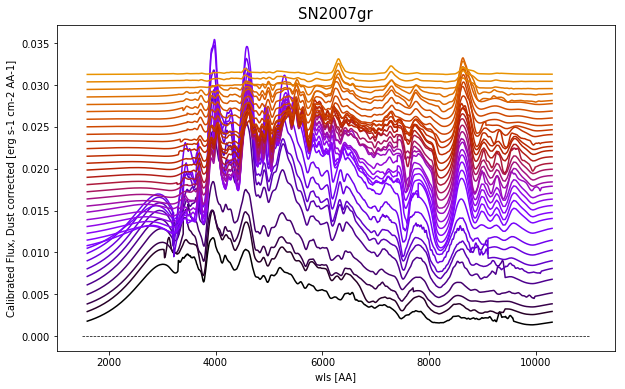

Choose one spec_file from this list:
['54408.00_spec_extended.txt', '54409.00_spec_extended.txt', '54410.00_spec_extended.txt', '54411.00_spec_extended.txt', '54412.00_spec_extended.txt', '54413.00_spec_extended.txt', '54414.00_spec_extended.txt', '54415.00_spec_extended.txt', '54417.00_spec_extended.txt', '54418.00_spec_extended.txt', '54419.00_spec_extended.txt', '54440.00_spec_extended.txt', '54448.00_spec_extended.txt']
54408.00_spec_extended.txt
self.spec_file 54408.00_spec_extended.txt
SCALE: 0.1133
SCALE: 6405454.5468
SCALE: 6405458.0964
SCALE: 6405461.6460
SCALE: 6405465.1956
SCALE: 6405468.7453
ITERATION 5 5
54409.00_spec_extended.txt
self.spec_file 54409.00_spec_extended.txt
SCALE: 0.1194
SCALE: 54996.1511
SCALE: 54997.7000
SCALE: 54999.2488
SCALE: 55000.7973
SCALE: 55002.3457
ITERATION 5 5
54410.00_spec_extended.txt
self.spec_file 54410.00_spec_extended.txt
SCALE: 0.2938
SCALE: 37915037.4356
SCALE: 37915045.7552
SCALE: 37915054.0747
SCALE: 37915062.3940
SCALE: 37915070.7132


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


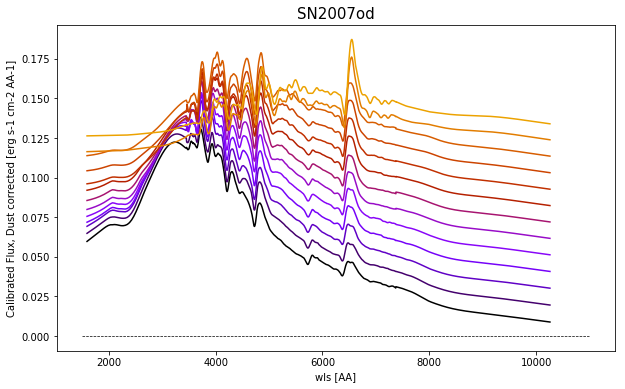

Choose one spec_file from this list:
['54415.50_spec_extended.txt', '54416.50_spec_extended.txt', '54421.50_spec_extended.txt', '54438.50_spec_extended.txt', '54462.50_spec_extended.txt', '54476.50_spec_extended.txt', '54493.50_spec_extended.txt']
54415.50_spec_extended.txt
self.spec_file 54415.50_spec_extended.txt
SCALE: 0.0447
SCALE: 0.2866
SCALE: 0.2866
SCALE: 0.2866
SCALE: 0.2866
SCALE: 0.2866
ITERATION 5 5
54416.50_spec_extended.txt
self.spec_file 54416.50_spec_extended.txt
SCALE: 0.0051
SCALE: 0.0124
SCALE: 0.0213
SCALE: 0.0419
SCALE: 0.0139
SCALE: 0.0190
ITERATION 5 5
54421.50_spec_extended.txt
self.spec_file 54421.50_spec_extended.txt
SCALE: 0.0054
SCALE: 8578.6762
SCALE: 8578.6250
SCALE: 8578.5739
SCALE: 8578.5229
SCALE: 8578.4721
ITERATION 5 5
54438.50_spec_extended.txt
self.spec_file 54438.50_spec_extended.txt
SCALE: 0.0053
SCALE: 2.2873
SCALE: 2.2873
SCALE: 2.2873
SCALE: 2.2873
SCALE: 2.2873
ITERATION 5 5
54462.50_spec_extended.txt
self.spec_file 54462.50_spec_extended.txt


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


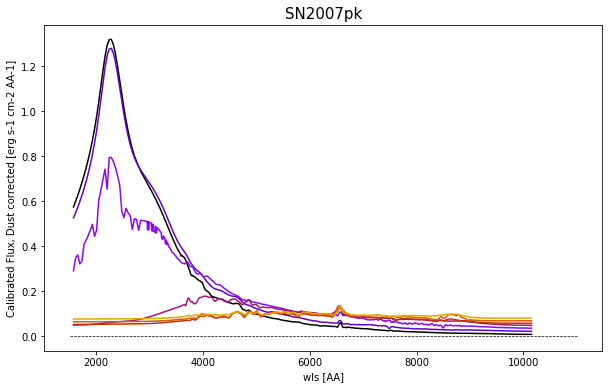

Choose one spec_file from this list:
['54435.10_spec_extended.txt', '54437.00_spec_extended.txt', '54440.00_spec_extended.txt', '54445.10_spec_extended.txt', '54476.00_spec_extended.txt']
54435.10_spec_extended.txt
self.spec_file 54435.10_spec_extended.txt
SCALE: 0.0050
SCALE: 55872.9031
SCALE: 55872.5227
SCALE: 55872.1423
SCALE: 55871.7620
SCALE: 55871.3816
ITERATION 5 5
54437.00_spec_extended.txt
self.spec_file 54437.00_spec_extended.txt
SCALE: 0.0053
SCALE: 0.0051
SCALE: 0.0050
SCALE: 0.0060
SCALE: 0.0074
SCALE: 0.0050
ITERATION 5 5
54440.00_spec_extended.txt
self.spec_file 54440.00_spec_extended.txt
SCALE: 0.0054
SCALE: 0.0052
SCALE: 0.0060
SCALE: 0.5577
SCALE: 7.5852
SCALE: 10.3546
ITERATION 5 5
54445.10_spec_extended.txt
self.spec_file 54445.10_spec_extended.txt
SCALE: 3.3458
SCALE: 13745.5252
SCALE: 13784.2428
SCALE: 13822.8237
SCALE: 13861.2692
SCALE: 13899.5804
ITERATION 5 5
54476.00_spec_extended.txt
self.spec_file 54476.00_spec_extended.txt
SCALE: 0.2347
SCALE: 0.2347
SCALE:

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


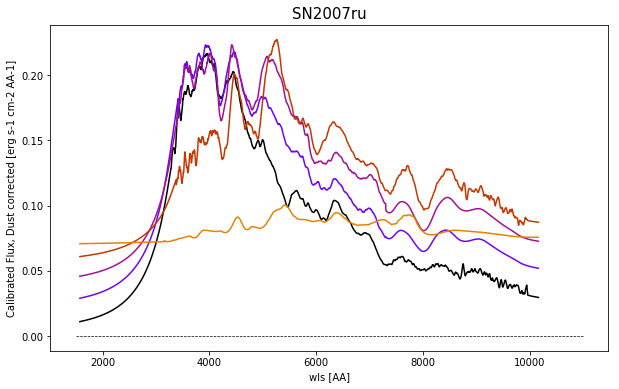

Choose one spec_file from this list:
['54470.08_spec_extended.txt', '54475.04_spec_extended.txt', '54476.04_spec_extended.txt', '54478.02_spec_extended.txt', '54480.00_spec_extended.txt', '54493.91_spec_extended.txt', '54526.68_spec_extended.txt', '54535.62_spec_extended.txt', '54537.00_spec_extended.txt', '54556.47_spec_extended.txt', '54622.01_spec_extended.txt']
54470.08_spec_extended.txt
self.spec_file 54470.08_spec_extended.txt
SCALE: 0.1026
SCALE: 0.0051
SCALE: 503516.0609
SCALE: 503511.4760
SCALE: 503506.8911
SCALE: 503502.3062
ITERATION 5 5
54475.04_spec_extended.txt
self.spec_file 54475.04_spec_extended.txt
SCALE: 0.0463
SCALE: 0.0300
SCALE: 18405705.6700
SCALE: 18405708.1035
SCALE: 18405710.5369
SCALE: 18405712.9704
ITERATION 5 5
54476.04_spec_extended.txt
self.spec_file 54476.04_spec_extended.txt
SCALE: 0.0139
SCALE: 6624212.8399
SCALE: 6624215.7897
SCALE: 6624218.7394
SCALE: 6624221.6892
SCALE: 6624224.6390
ITERATION 5 5
54478.02_spec_extended.txt
self.spec_file 54478.02_sp

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


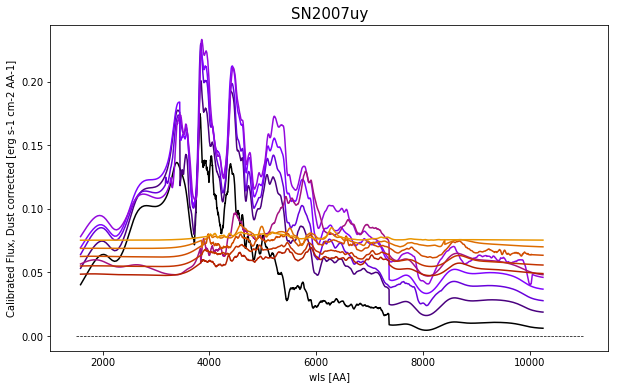

Choose one spec_file from this list:
['54477.00_spec_extended.txt', '54478.00_spec_extended.txt', '54479.00_spec_extended.txt', '54480.00_spec_extended.txt', '54480.07_spec_extended.txt', '54481.06_spec_extended.txt', '54483.00_spec_extended.txt', '54483.05_spec_extended.txt', '54486.00_spec_extended.txt', '54486.04_spec_extended.txt', '54490.02_spec_extended.txt', '54495.99_spec_extended.txt', '54497.98_spec_extended.txt', '54498.00_spec_extended.txt', '54498.98_spec_extended.txt', '54504.95_spec_extended.txt', '54506.94_spec_extended.txt', '54507.94_spec_extended.txt', '54508.00_spec_extended.txt', '54511.92_spec_extended.txt', '54512.00_spec_extended.txt', '54512.91_spec_extended.txt', '54520.88_spec_extended.txt', '54522.87_spec_extended.txt', '54524.00_spec_extended.txt', '54525.00_spec_extended.txt', '54534.81_spec_extended.txt', '54535.00_spec_extended.txt', '54584.00_spec_extended.txt']
54477.00_spec_extended.txt
self.spec_file 54477.00_spec_extended.txt
SCALE: 0.0878
SCALE: 19

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


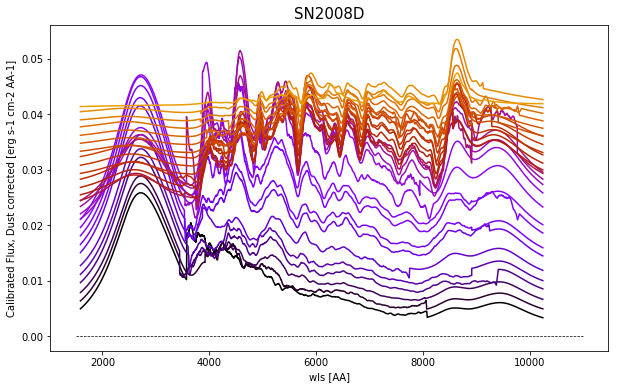

Choose one spec_file from this list:
['54524.45_spec_extended.txt', '54525.00_spec_extended.txt', '54525.41_spec_extended.txt', '54526.40_spec_extended.txt', '54527.42_spec_extended.txt', '54534.39_spec_extended.txt', '54584.00_spec_extended.txt']
54524.45_spec_extended.txt
self.spec_file 54524.45_spec_extended.txt
SCALE: 0.0052
SCALE: 0.1706
SCALE: 0.0611
SCALE: 0.0585
SCALE: 0.2647
SCALE: 0.3151
ITERATION 5 5
54525.00_spec_extended.txt
self.spec_file 54525.00_spec_extended.txt
SCALE: 0.0053
SCALE: 0.4535
SCALE: 2.0078
SCALE: 4.5563
SCALE: 8.1463
SCALE: 12.7740
ITERATION 5 5
54525.41_spec_extended.txt
self.spec_file 54525.41_spec_extended.txt
SCALE: 0.0122
SCALE: 6.2307
SCALE: 12.2912
SCALE: 20.5779
SCALE: 31.1686
SCALE: 44.0647
ITERATION 5 5
54526.40_spec_extended.txt
self.spec_file 54526.40_spec_extended.txt
SCALE: 0.0051
SCALE: 2.2414
SCALE: 2356.6857
SCALE: 2562.0091
SCALE: 2762.1980
SCALE: 2957.4049
ITERATION 5 5
54527.42_spec_extended.txt
self.spec_file 54527.42_spec_extended.tx

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


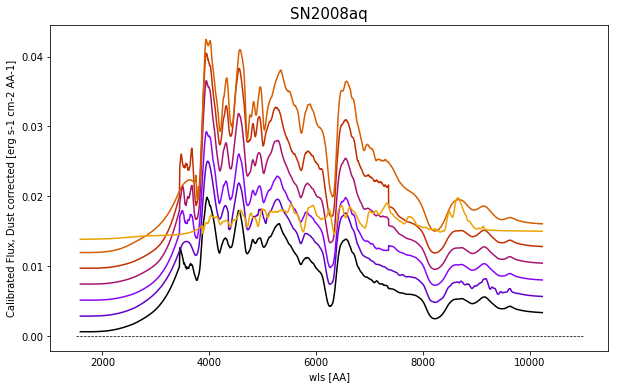

Choose one spec_file from this list:
['54529.04_spec_extended.txt', '54530.04_spec_extended.txt', '54531.04_spec_extended.txt', '54533.03_spec_extended.txt', '54534.03_spec_extended.txt', '54536.03_spec_extended.txt', '54537.00_spec_extended.txt', '54537.02_spec_extended.txt', '54538.02_spec_extended.txt', '54539.02_spec_extended.txt', '54540.02_spec_extended.txt', '54541.02_spec_extended.txt', '54543.01_spec_extended.txt', '54545.01_spec_extended.txt', '54548.00_spec_extended.txt', '54550.00_spec_extended.txt', '54552.99_spec_extended.txt', '54554.99_spec_extended.txt', '54555.00_spec_extended.txt', '54555.99_spec_extended.txt', '54556.99_spec_extended.txt', '54557.98_spec_extended.txt', '54559.98_spec_extended.txt', '54560.98_spec_extended.txt', '54563.97_spec_extended.txt', '54564.00_spec_extended.txt', '54564.97_spec_extended.txt', '54567.96_spec_extended.txt', '54569.00_spec_extended.txt', '54569.96_spec_extended.txt', '54571.96_spec_extended.txt', '54581.00_spec_extended.txt', '5

SCALE: 159547.2237
ITERATION 5 5
54593.92_spec_extended.txt
self.spec_file 54593.92_spec_extended.txt
SCALE: 248311.3149
SCALE: 248311.9661
SCALE: 248312.6173
SCALE: 248313.2684
SCALE: 248313.9195
SCALE: 248314.5705
ITERATION 5 5
54595.91_spec_extended.txt
self.spec_file 54595.91_spec_extended.txt
SCALE: 0.0982
SCALE: 246203.4713
SCALE: 246206.4889
SCALE: 246209.5064
SCALE: 246212.5239
SCALE: 246215.5414
ITERATION 5 5
54613.00_spec_extended.txt
self.spec_file 54613.00_spec_extended.txt
SCALE: 0.6307
SCALE: 0.6307
SCALE: 0.6307
SCALE: 0.6307
SCALE: 0.6307
SCALE: 0.6307
ITERATION 5 5
54646.00_spec_extended.txt
self.spec_file 54646.00_spec_extended.txt
SCALE: 7724373.3670
SCALE: 7724374.0593
SCALE: 7724374.7516
SCALE: 7724375.4439
SCALE: 7724376.1362
SCALE: 7724376.8285
ITERATION 5 5
54686.00_spec_extended.txt
self.spec_file 54686.00_spec_extended.txt
SCALE: 43.3030
SCALE: 89.6815
SCALE: 125.9375
SCALE: 166.1731
SCALE: 203.3285
SCALE: 237.7422
ITERATION 5 5


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


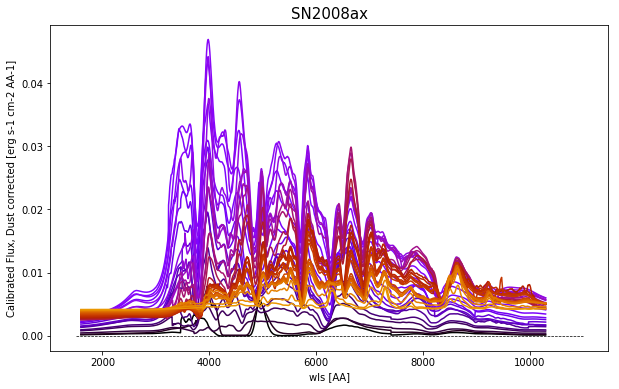

Choose one spec_file from this list:
['54552.00_spec_extended.txt', '54554.00_spec_extended.txt', '54556.00_spec_extended.txt', '54557.00_spec_extended.txt', '54558.00_spec_extended.txt', '54560.00_spec_extended.txt', '54562.00_spec_extended.txt', '54563.00_spec_extended.txt', '54565.00_spec_extended.txt', '54567.00_spec_extended.txt', '54582.00_spec_extended.txt', '54586.00_spec_extended.txt', '54592.00_spec_extended.txt', '54615.00_spec_extended.txt', '54623.00_spec_extended.txt', '54628.00_spec_extended.txt']
54552.00_spec_extended.txt
self.spec_file 54552.00_spec_extended.txt
SCALE: 0.0054
SCALE: 0.1412
SCALE: 2.4096
SCALE: 13.1988
SCALE: 29.9249
SCALE: 55.2845
ITERATION 5 5
54554.00_spec_extended.txt
self.spec_file 54554.00_spec_extended.txt
SCALE: 0.0106
SCALE: 54320.9808
SCALE: 54321.3196
SCALE: 54321.6585
SCALE: 54321.9974
SCALE: 54322.3363
ITERATION 5 5
54556.00_spec_extended.txt
self.spec_file 54556.00_spec_extended.txt
SCALE: 0.1504
SCALE: 853695.7057
SCALE: 853696.2838
SCAL

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


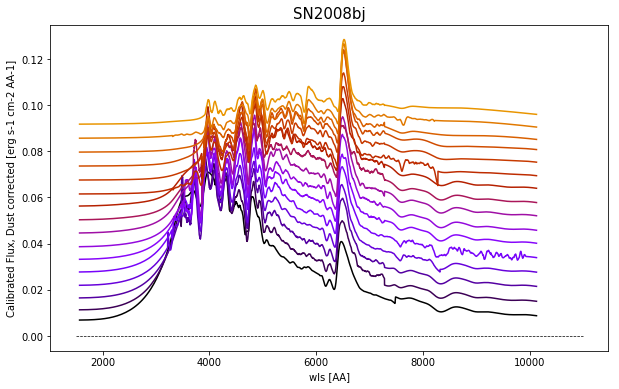

Choose one spec_file from this list:
['54560.00_spec_extended.txt', '54562.03_spec_extended.txt', '54566.01_spec_extended.txt', '54568.00_spec_extended.txt', '54573.00_spec_extended.txt', '54584.00_spec_extended.txt', '54584.92_spec_extended.txt', '54589.90_spec_extended.txt', '54593.88_spec_extended.txt', '54599.85_spec_extended.txt', '54613.78_spec_extended.txt', '54622.73_spec_extended.txt', '54654.00_spec_extended.txt']
54560.00_spec_extended.txt
self.spec_file 54560.00_spec_extended.txt
SCALE: 238915.7150
SCALE: 238915.9542
SCALE: 238916.1934
SCALE: 238916.4325
SCALE: 238916.6717
SCALE: 238916.9108
ITERATION 5 5
54562.03_spec_extended.txt
self.spec_file 54562.03_spec_extended.txt
SCALE: 0.5267
SCALE: 176963805.5452
SCALE: 176963805.5282
SCALE: 176963805.5168
SCALE: 176963805.5012
SCALE: 176963805.4849
ITERATION 5 5
54566.01_spec_extended.txt
self.spec_file 54566.01_spec_extended.txt
SCALE: 0.0525
SCALE: 11407828.9206
SCALE: 11407828.9238
SCALE: 11407828.9270
SCALE: 11407828.9303
S

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


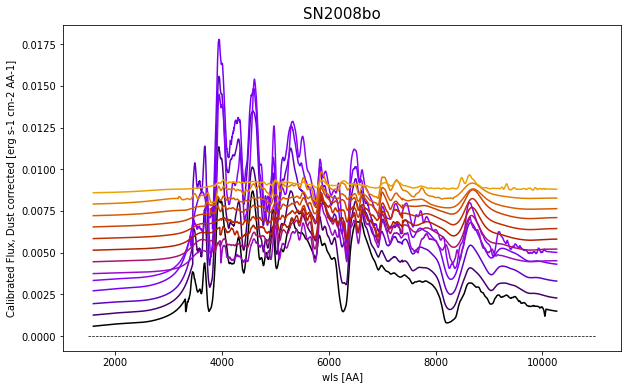

Choose one spec_file from this list:
['54726.00_spec_extended.txt', '54731.00_spec_extended.txt', '54738.00_spec_extended.txt', '54739.00_spec_extended.txt', '54746.00_spec_extended.txt', '54753.00_spec_extended.txt', '54753.01_spec_extended.txt', '54766.00_spec_extended.txt', '54777.00_spec_extended.txt', '54790.14_spec_extended.txt']
54726.00_spec_extended.txt
self.spec_file 54726.00_spec_extended.txt
SCALE: 0.0139
SCALE: 0.0139
SCALE: 0.0139
SCALE: 0.0139
SCALE: 0.0139
SCALE: 0.0139
ITERATION 5 5
54731.00_spec_extended.txt
self.spec_file 54731.00_spec_extended.txt
SCALE: 0.0077
SCALE: 0.0051
SCALE: 0.0098
SCALE: 0.0183
SCALE: 0.0236
SCALE: 0.0213
ITERATION 5 5
54738.00_spec_extended.txt
self.spec_file 54738.00_spec_extended.txt
SCALE: 0.0071
SCALE: 0.0052
SCALE: 0.0055
SCALE: 0.0059
SCALE: 0.0093
SCALE: 0.0060
ITERATION 5 5
54739.00_spec_extended.txt
self.spec_file 54739.00_spec_extended.txt
SCALE: 0.0096
SCALE: 0.0087
SCALE: 0.0097
SCALE: 0.0062
SCALE: 0.0062
SCALE: 0.0084
ITERATIO

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


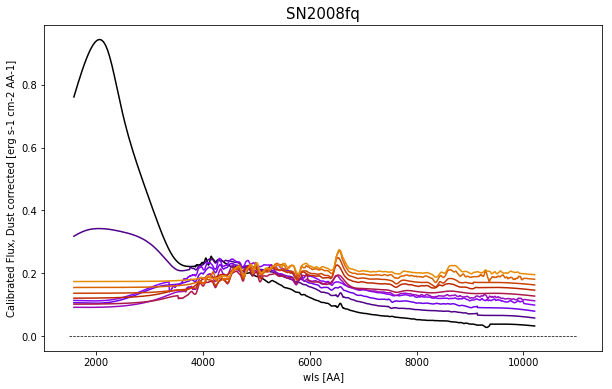

Choose one spec_file from this list:
['54831.95_spec_extended.txt', '54838.93_spec_extended.txt', '54879.82_spec_extended.txt', '54884.92_spec_extended.txt', '54912.85_spec_extended.txt', '54915.92_spec_extended.txt', '54924.80_spec_extended.txt', '54924.87_spec_extended.txt', '54944.75_spec_extended.txt', '54968.10_spec_extended.txt']
54831.95_spec_extended.txt
self.spec_file 54831.95_spec_extended.txt
SCALE: 0.0055
SCALE: 0.0061
SCALE: 0.0067
SCALE: 0.0073
SCALE: 0.0077
SCALE: 0.0082
ITERATION 5 5
54838.93_spec_extended.txt
self.spec_file 54838.93_spec_extended.txt
SCALE: 0.0574
SCALE: 58772173.5912
SCALE: 58772170.6679
SCALE: 58772167.7433
SCALE: 58772164.8199
SCALE: 58772161.8951
ITERATION 5 5
54879.82_spec_extended.txt
self.spec_file 54879.82_spec_extended.txt
SCALE: 0.0231
SCALE: 99.5263
SCALE: 5289327.1662
SCALE: 5289573.2846
SCALE: 5289819.3897
SCALE: 5290065.4817
ITERATION 5 5
54884.92_spec_extended.txt
self.spec_file 54884.92_spec_extended.txt
SCALE: 1.9272
SCALE: 86311155.21

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


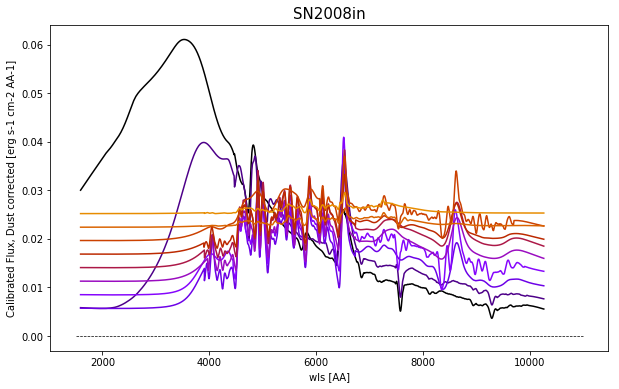

Choose one spec_file from this list:
['54870.30_spec_extended.txt', '54871.27_spec_extended.txt', '54873.31_spec_extended.txt', '54881.09_spec_extended.txt', '54882.08_spec_extended.txt', '54886.32_spec_extended.txt', '54887.35_spec_extended.txt', '54888.34_spec_extended.txt', '54905.34_spec_extended.txt', '54905.35_spec_extended.txt', '54909.00_spec_extended.txt', '54910.01_spec_extended.txt', '54919.30_spec_extended.txt', '54924.23_spec_extended.txt', '54933.01_spec_extended.txt', '54937.02_spec_extended.txt', '54939.16_spec_extended.txt', '54944.26_spec_extended.txt', '54952.16_spec_extended.txt', '54954.90_spec_extended.txt', '54960.90_spec_extended.txt', '54974.11_spec_extended.txt']
54870.30_spec_extended.txt
self.spec_file 54870.30_spec_extended.txt
SCALE: 0.1704
SCALE: 0.1168
SCALE: 0.0955
SCALE: 0.2478
SCALE: 0.3077
SCALE: 0.3564
ITERATION 5 5
54871.27_spec_extended.txt
self.spec_file 54871.27_spec_extended.txt
SCALE: 0.0870
SCALE: 0.4179
SCALE: 0.6686
SCALE: 0.9600
SCALE: 1.2

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


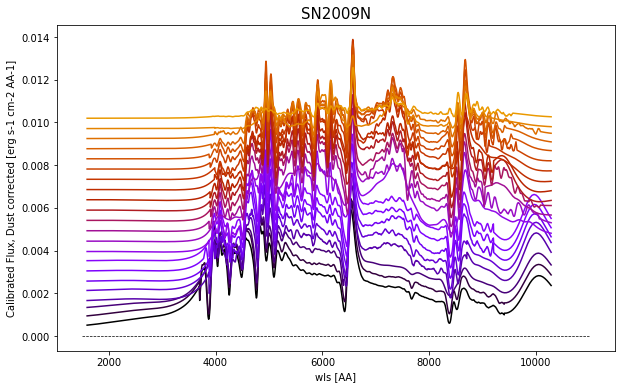

Choose one spec_file from this list:
['54918.00_spec_extended.txt', '54919.00_spec_extended.txt', '54924.00_spec_extended.txt', '54929.00_spec_extended.txt', '54929.01_spec_extended.txt', '54938.10_spec_extended.txt', '54939.08_spec_extended.txt', '54943.08_spec_extended.txt', '54944.11_spec_extended.txt', '54947.00_spec_extended.txt', '54951.13_spec_extended.txt', '54965.03_spec_extended.txt']
54918.00_spec_extended.txt
self.spec_file 54918.00_spec_extended.txt
SCALE: 0.0053
SCALE: 0.1120
SCALE: 0.1120
SCALE: 0.1120
SCALE: 0.1120
SCALE: 0.1120
ITERATION 5 5
54919.00_spec_extended.txt
self.spec_file 54919.00_spec_extended.txt
SCALE: 0.0052
SCALE: 0.0071
SCALE: 0.0050
SCALE: 0.0063
SCALE: 0.0054
SCALE: 0.0054
ITERATION 5 5
54924.00_spec_extended.txt
self.spec_file 54924.00_spec_extended.txt
SCALE: 21953.6163
SCALE: 21952.1058
SCALE: 21950.5967
SCALE: 21949.0889
SCALE: 21947.5826
SCALE: 21946.0776
ITERATION 5 5
54929.00_spec_extended.txt
self.spec_file 54929.00_spec_extended.txt
SCALE: 0

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


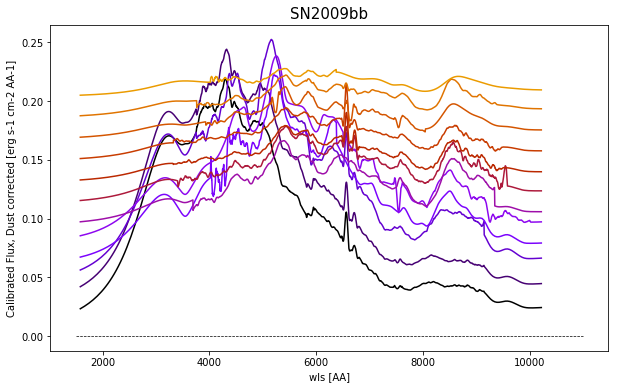

Choose one spec_file from this list:
['54933.83_spec_extended.txt', '54935.92_spec_extended.txt', '54949.86_spec_extended.txt', '54952.00_spec_extended.txt', '54953.00_spec_extended.txt', '54954.85_spec_extended.txt', '54967.00_spec_extended.txt', '54979.00_spec_extended.txt', '54980.00_spec_extended.txt', '54983.10_spec_extended.txt', '55009.11_spec_extended.txt', '55031.03_spec_extended.txt', '55056.07_spec_extended.txt', '55057.03_spec_extended.txt', '55079.07_spec_extended.txt', '55116.00_spec_extended.txt']
54933.83_spec_extended.txt
self.spec_file 54933.83_spec_extended.txt
SCALE: 0.3640
SCALE: 0.3640
SCALE: 0.3640
SCALE: 0.3640
SCALE: 0.3640
SCALE: 0.3640
ITERATION 5 5
54935.92_spec_extended.txt
self.spec_file 54935.92_spec_extended.txt
SCALE: 0.0873
SCALE: 0.7473
SCALE: 2.7518
SCALE: 6.3019
SCALE: 11.2485
SCALE: 17.5808
ITERATION 5 5
54949.86_spec_extended.txt
self.spec_file 54949.86_spec_extended.txt
SCALE: 21697127.9779
SCALE: 21697128.9049
SCALE: 21697129.8324
SCALE: 2169713

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


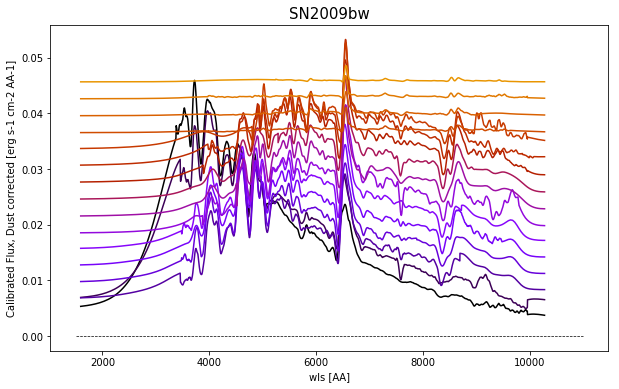

Choose one spec_file from this list:
['54936.00_spec_extended.txt', '54937.00_spec_extended.txt', '54971.00_spec_extended.txt', '55032.00_spec_extended.txt', '55155.00_spec_extended.txt', '55157.00_spec_extended.txt']
54936.00_spec_extended.txt
self.spec_file 54936.00_spec_extended.txt
SCALE: 0.0051
SCALE: 0.1129
SCALE: 0.0304
SCALE: 0.0304
SCALE: 0.0304
SCALE: 0.0304
ITERATION 5 5
54937.00_spec_extended.txt
self.spec_file 54937.00_spec_extended.txt
SCALE: 0.0051
SCALE: 0.0420
SCALE: 421142.2107
SCALE: 421142.7708
SCALE: 421143.3310
SCALE: 421143.8911
ITERATION 5 5
54971.00_spec_extended.txt
self.spec_file 54971.00_spec_extended.txt
SCALE: 0.0052
SCALE: 0.5841
SCALE: 0.5841
SCALE: 0.5841
SCALE: 0.5841
SCALE: 0.5841
ITERATION 5 5
55032.00_spec_extended.txt
self.spec_file 55032.00_spec_extended.txt
SCALE: 0.4318
SCALE: 1623419.4077
SCALE: 1623421.6521
SCALE: 1623423.8966
SCALE: 1623426.1410
SCALE: 1623428.3854
ITERATION 5 5
55155.00_spec_extended.txt
self.spec_file 55155.00_spec_extended

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


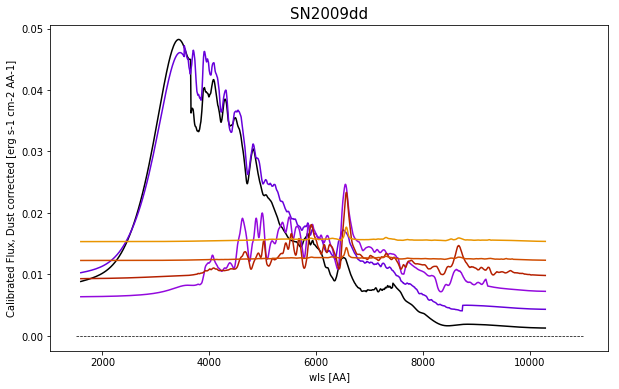

Choose one spec_file from this list:
['55052.00_spec_extended.txt', '55056.28_spec_extended.txt', '55086.38_spec_extended.txt', '55124.34_spec_extended.txt', '55157.16_spec_extended.txt', '55190.18_spec_extended.txt', '55221.19_spec_extended.txt', '55260.06_spec_extended.txt', '55303.98_spec_extended.txt']
55052.00_spec_extended.txt
self.spec_file 55052.00_spec_extended.txt


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/george/kernels.py:95: RuntimeWarning: divide by zero encountered in log
  log_constant = np.log(float(b)/self.ndim)


SCALE: 0.3000
ITERATION 0 0
55056.28_spec_extended.txt
self.spec_file 55056.28_spec_extended.txt
SCALE: 0.0050
SCALE: 0.2099
SCALE: 19318.1940
SCALE: 19321.2775
SCALE: 19324.5707
SCALE: 19328.0686
ITERATION 5 5
55086.38_spec_extended.txt
self.spec_file 55086.38_spec_extended.txt
SCALE: 0.0050
SCALE: 0.0052
SCALE: 0.2494
SCALE: 0.2494
SCALE: 0.2494
SCALE: 0.2494
ITERATION 5 5
55124.34_spec_extended.txt
self.spec_file 55124.34_spec_extended.txt
SCALE: 0.0925
SCALE: 1.5521
SCALE: 5.2089
SCALE: 11.1880
SCALE: 19.1117
SCALE: 28.8106
ITERATION 5 5
55157.16_spec_extended.txt
self.spec_file 55157.16_spec_extended.txt
SCALE: 0.2841
SCALE: 7.1715
SCALE: 9.8061
SCALE: 12.5924
SCALE: 15.4362
SCALE: 19.2463
ITERATION 5 5
55190.18_spec_extended.txt
self.spec_file 55190.18_spec_extended.txt
SCALE: 70654907.4251
SCALE: 70654907.4790
SCALE: 70654907.5321
SCALE: 70654907.5859
SCALE: 70654907.6397
SCALE: 70654907.6937
ITERATION 5 5
55221.19_spec_extended.txt
self.spec_file 55221.19_spec_extended.txt
SCAL

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


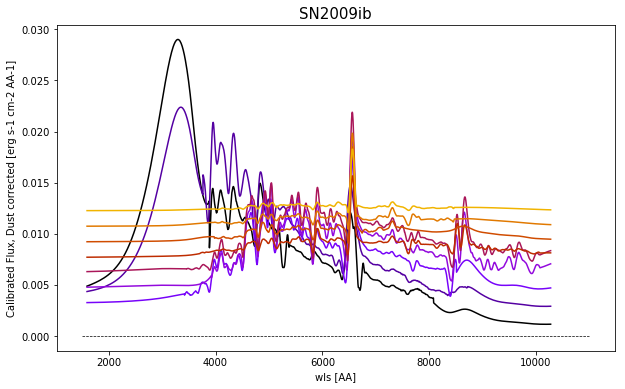

Choose one spec_file from this list:
['56193.50_spec_extended.txt', '56195.50_spec_extended.txt', '56196.25_spec_extended.txt', '56197.38_spec_extended.txt', '56197.50_spec_extended.txt', '56198.07_spec_extended.txt', '56198.50_spec_extended.txt', '56199.44_spec_extended.txt', '56199.50_spec_extended.txt', '56200.24_spec_extended.txt', '56201.05_spec_extended.txt', '56201.50_spec_extended.txt', '56202.09_spec_extended.txt', '56202.50_spec_extended.txt', '56203.12_spec_extended.txt', '56203.50_spec_extended.txt', '56204.38_spec_extended.txt', '56204.50_spec_extended.txt', '56205.38_spec_extended.txt', '56205.50_spec_extended.txt', '56206.19_spec_extended.txt', '56208.32_spec_extended.txt', '56208.50_spec_extended.txt', '56209.50_spec_extended.txt', '56210.13_spec_extended.txt', '56210.24_spec_extended.txt', '56211.43_spec_extended.txt', '56212.26_spec_extended.txt', '56213.18_spec_extended.txt', '56214.20_spec_extended.txt', '56214.50_spec_extended.txt', '56215.50_spec_extended.txt', '5

ITERATION 5 5
56216.50_spec_extended.txt
self.spec_file 56216.50_spec_extended.txt
SCALE: 0.0524
SCALE: 1.5442
SCALE: 1.5443
SCALE: 1.5443
SCALE: 1.5443
SCALE: 1.5443
ITERATION 5 5
56220.25_spec_extended.txt
self.spec_file 56220.25_spec_extended.txt
SCALE: 0.0054
SCALE: 0.1568
SCALE: 0.1568
SCALE: 0.1568
SCALE: 0.1568
SCALE: 0.1568
ITERATION 5 5
56220.35_spec_extended.txt
self.spec_file 56220.35_spec_extended.txt
SCALE: 0.0987
SCALE: 124221.9620
SCALE: 124226.6815
SCALE: 124231.4010
SCALE: 124236.1204
SCALE: 124240.8398
ITERATION 5 5
56221.16_spec_extended.txt
self.spec_file 56221.16_spec_extended.txt
SCALE: 0.1554
SCALE: 1.1422
SCALE: 1.1422
SCALE: 1.1422
SCALE: 1.1422
SCALE: 1.1422
ITERATION 5 5
56222.42_spec_extended.txt
self.spec_file 56222.42_spec_extended.txt
SCALE: 0.0094
SCALE: 0.0050
SCALE: 0.0124
SCALE: 0.0061
SCALE: 0.0088
SCALE: 0.0080
ITERATION 5 5
56222.50_spec_extended.txt
self.spec_file 56222.50_spec_extended.txt
SCALE: 0.8526
SCALE: 2.6313
SCALE: 5.0024
SCALE: 8.0291
S

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


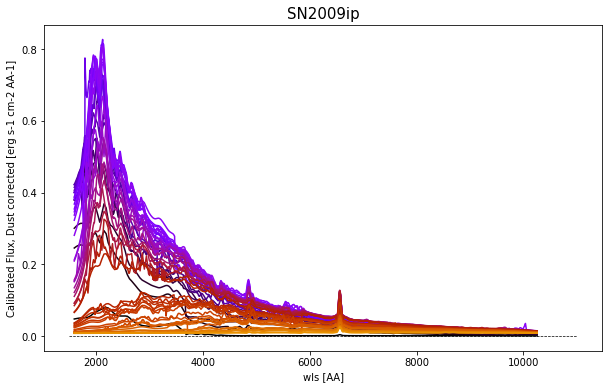

Choose one spec_file from this list:
['55095.19_spec_extended.txt', '55096.00_spec_extended.txt', '55099.13_spec_extended.txt', '55113.92_spec_extended.txt', '55119.84_spec_extended.txt', '55120.82_spec_extended.txt', '55121.81_spec_extended.txt', '55129.70_spec_extended.txt', '55150.40_spec_extended.txt', '55156.32_spec_extended.txt']
55095.19_spec_extended.txt
self.spec_file 55095.19_spec_extended.txt
SCALE: 72351.9508
SCALE: 72395.7092
SCALE: 72439.4417
SCALE: 72483.1484
SCALE: 72526.8293
SCALE: 72570.4845
ITERATION 5 5
55096.00_spec_extended.txt
self.spec_file 55096.00_spec_extended.txt
SCALE: 0.3522
SCALE: 1.4913
SCALE: 2.3630
SCALE: 3.2806
SCALE: 4.2519
SCALE: 5.2699
ITERATION 5 5
55099.13_spec_extended.txt
self.spec_file 55099.13_spec_extended.txt
SCALE: 0.0116
SCALE: 0.1756
SCALE: 1.7705
SCALE: 6.3046
SCALE: 15.1952
SCALE: 28.9628
ITERATION 5 5
55113.92_spec_extended.txt
self.spec_file 55113.92_spec_extended.txt
SCALE: 0.5223
SCALE: 471300473.1260
SCALE: 471300474.0450
SCALE: 4

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


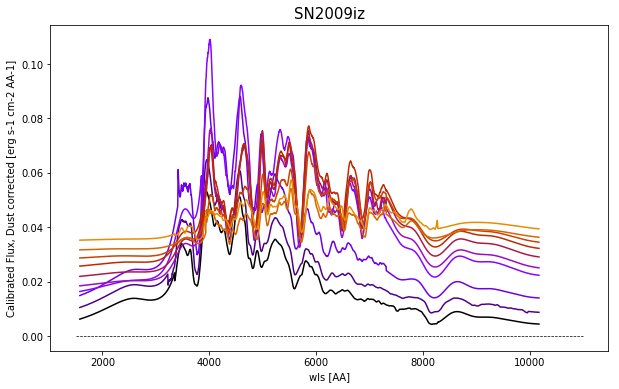

Choose one spec_file from this list:
['55106.00_spec_extended.txt', '55108.00_spec_extended.txt', '55110.00_spec_extended.txt', '55111.00_spec_extended.txt', '55114.24_spec_extended.txt', '55116.33_spec_extended.txt', '55117.00_spec_extended.txt', '55118.21_spec_extended.txt', '55120.00_spec_extended.txt', '55121.17_spec_extended.txt', '55122.00_spec_extended.txt', '55124.10_spec_extended.txt', '55125.29_spec_extended.txt', '55130.17_spec_extended.txt', '55131.14_spec_extended.txt', '55132.00_spec_extended.txt', '55139.00_spec_extended.txt', '55145.25_spec_extended.txt', '55148.00_spec_extended.txt', '55151.28_spec_extended.txt', '55154.00_spec_extended.txt', '55155.13_spec_extended.txt', '55170.00_spec_extended.txt', '55176.08_spec_extended.txt', '55180.14_spec_extended.txt', '55182.16_spec_extended.txt', '55192.00_spec_extended.txt', '55202.10_spec_extended.txt', '55203.00_spec_extended.txt', '55233.21_spec_extended.txt', '55366.38_spec_extended.txt']
55106.00_spec_extended.txt
self.

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


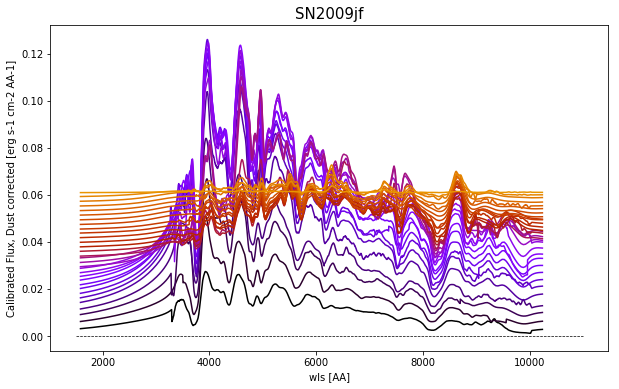

Choose one spec_file from this list:
['55145.00_spec_extended.txt', '55160.00_spec_extended.txt', '55174.00_spec_extended.txt', '55183.00_spec_extended.txt', '55204.00_spec_extended.txt', '55216.00_spec_extended.txt']
55145.00_spec_extended.txt
self.spec_file 55145.00_spec_extended.txt
SCALE: 1.3852
SCALE: 1.3852
SCALE: 1.3852
SCALE: 1.3852
SCALE: 1.3852
SCALE: 1.3852
ITERATION 5 5
55160.00_spec_extended.txt
self.spec_file 55160.00_spec_extended.txt
SCALE: 2.6477
SCALE: 2889725.2192
SCALE: 2889731.1886
SCALE: 2889737.1580
SCALE: 2889743.1273
SCALE: 2889749.0967
ITERATION 5 5
55174.00_spec_extended.txt
self.spec_file 55174.00_spec_extended.txt
SCALE: 28332558.4648
SCALE: 28332559.9098
SCALE: 28332561.3553
SCALE: 28332562.8006
SCALE: 28332564.2455
SCALE: 28332565.6908
ITERATION 5 5
55183.00_spec_extended.txt
self.spec_file 55183.00_spec_extended.txt
SCALE: 0.1926
SCALE: 0.1926
SCALE: 0.1926
SCALE: 0.1926
SCALE: 0.1926
SCALE: 0.1926
ITERATION 5 5
55204.00_spec_extended.txt
self.spec_file 

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


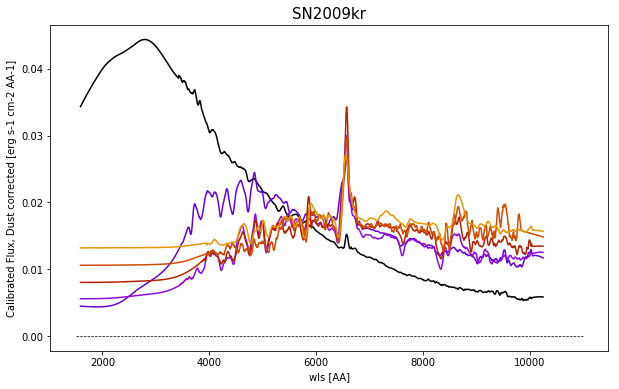

Choose one spec_file from this list:
['55273.00_spec_extended.txt', '55275.00_spec_extended.txt', '55280.00_spec_extended.txt', '55284.00_spec_extended.txt', '55285.00_spec_extended.txt', '55287.00_spec_extended.txt', '55293.00_spec_extended.txt', '55304.00_spec_extended.txt', '55315.00_spec_extended.txt', '55323.22_spec_extended.txt', '55327.00_spec_extended.txt']
55273.00_spec_extended.txt
self.spec_file 55273.00_spec_extended.txt
SCALE: 0.0065
SCALE: 0.0056
SCALE: 0.0057
SCALE: 0.0075
SCALE: 0.0064
SCALE: 0.0051
ITERATION 5 5
55275.00_spec_extended.txt
self.spec_file 55275.00_spec_extended.txt
SCALE: 0.0060
SCALE: 0.0073
SCALE: 0.0082
SCALE: 0.0107
SCALE: 0.0109
SCALE: 0.0108
ITERATION 5 5
55280.00_spec_extended.txt
self.spec_file 55280.00_spec_extended.txt
This spectrum has a huge amount of data points(17551), Im chopping a 3 th of them
SCALE: 0.0114
This spectrum has a huge amount of data points(17551), Im chopping a 3 th of them
SCALE: 0.2481
This spectrum has a huge amount of da

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


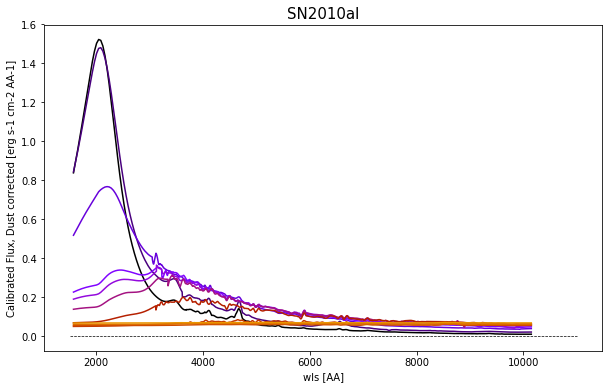

Choose one spec_file from this list:
['55662.03_spec_extended.txt', '55665.04_spec_extended.txt', '55669.96_spec_extended.txt', '55671.91_spec_extended.txt', '55675.11_spec_extended.txt', '55689.00_spec_extended.txt', '55696.98_spec_extended.txt', '55703.87_spec_extended.txt', '55724.07_spec_extended.txt', '55736.01_spec_extended.txt', '55783.85_spec_extended.txt', '55784.85_spec_extended.txt', '55948.35_spec_extended.txt']
55662.03_spec_extended.txt
self.spec_file 55662.03_spec_extended.txt
SCALE: 0.0132
SCALE: 2748.1049
SCALE: 2763.5699
SCALE: 2779.7237
SCALE: 2796.5900
SCALE: 2814.1935
ITERATION 5 5
55665.04_spec_extended.txt
self.spec_file 55665.04_spec_extended.txt
SCALE: 0.0734
SCALE: 0.0734
SCALE: 0.0734
SCALE: 0.0734
SCALE: 0.0734
SCALE: 0.0734
ITERATION 5 5
55669.96_spec_extended.txt
self.spec_file 55669.96_spec_extended.txt
SCALE: 0.0057
SCALE: 0.1090
SCALE: 0.1091
SCALE: 0.1091
SCALE: 0.1092
SCALE: 0.1092
ITERATION 5 5
55671.91_spec_extended.txt
self.spec_file 55671.91_spec_

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


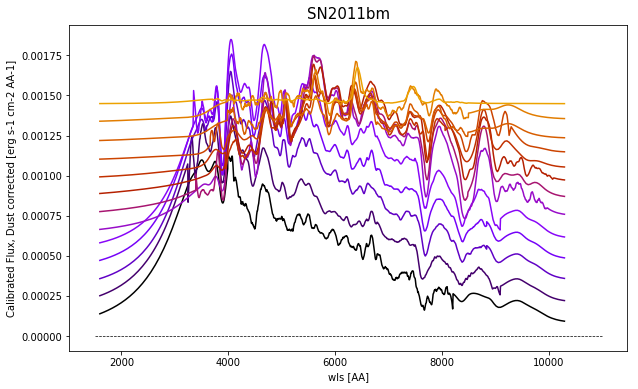

Choose one spec_file from this list:
['55715.33_spec_extended.txt', '55716.00_spec_extended.txt', '55717.92_spec_extended.txt', '55718.90_spec_extended.txt', '55719.00_spec_extended.txt', '55720.95_spec_extended.txt', '55721.38_spec_extended.txt', '55722.06_spec_extended.txt', '55724.88_spec_extended.txt', '55729.95_spec_extended.txt', '55732.92_spec_extended.txt', '55737.99_spec_extended.txt', '55741.00_spec_extended.txt', '55742.23_spec_extended.txt', '55747.90_spec_extended.txt', '55748.24_spec_extended.txt', '55752.91_spec_extended.txt', '55756.89_spec_extended.txt', '55760.88_spec_extended.txt', '55761.89_spec_extended.txt', '55764.90_spec_extended.txt', '55770.91_spec_extended.txt', '55778.18_spec_extended.txt', '55779.89_spec_extended.txt', '55794.89_spec_extended.txt', '55801.87_spec_extended.txt', '55803.86_spec_extended.txt', '55811.86_spec_extended.txt', '55820.83_spec_extended.txt', '55827.85_spec_extended.txt', '55864.15_spec_extended.txt', '55867.21_spec_extended.txt', '5

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


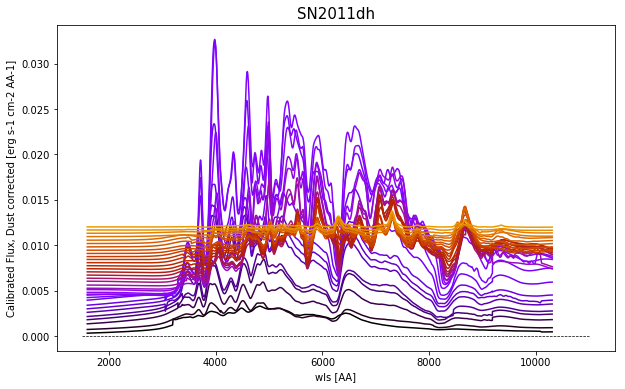

Choose one spec_file from this list:
['55771.00_spec_extended.txt', '55775.00_spec_extended.txt', '55779.00_spec_extended.txt', '55781.00_spec_extended.txt', '55789.00_spec_extended.txt', '55794.00_spec_extended.txt', '55799.00_spec_extended.txt', '55802.00_spec_extended.txt', '55824.00_spec_extended.txt', '55834.00_spec_extended.txt', '55852.00_spec_extended.txt']
55771.00_spec_extended.txt
self.spec_file 55771.00_spec_extended.txt
SCALE: 0.0051
SCALE: 0.0051
SCALE: 0.0075
SCALE: 0.0117
SCALE: 0.0101
SCALE: 0.0066
ITERATION 5 5
55775.00_spec_extended.txt
self.spec_file 55775.00_spec_extended.txt
SCALE: 0.6581
SCALE: 0.6581
SCALE: 0.6581
SCALE: 0.6581
SCALE: 0.6581
SCALE: 0.6581
ITERATION 5 5
55779.00_spec_extended.txt
self.spec_file 55779.00_spec_extended.txt
SCALE: 0.0106
SCALE: 1.2143
SCALE: 1.4418
SCALE: 1.6840
SCALE: 1.9423
SCALE: 2.2175
ITERATION 5 5
55781.00_spec_extended.txt
self.spec_file 55781.00_spec_extended.txt
SCALE: 0.1493
SCALE: 0.2442
SCALE: 0.2961
SCALE: 0.3362
SCALE:

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


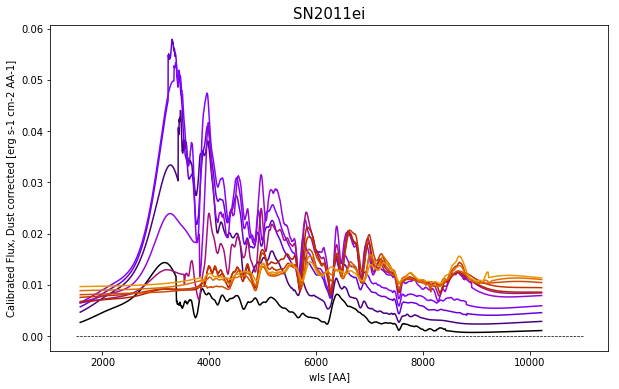

Choose one spec_file from this list:
['55827.80_spec_extended.txt', '55828.00_spec_extended.txt', '55830.38_spec_extended.txt', '55832.00_spec_extended.txt', '55833.10_spec_extended.txt', '55834.80_spec_extended.txt', '55835.00_spec_extended.txt', '55837.00_spec_extended.txt', '55840.90_spec_extended.txt', '55844.10_spec_extended.txt', '55848.00_spec_extended.txt', '55851.10_spec_extended.txt', '55858.00_spec_extended.txt', '55859.39_spec_extended.txt', '55863.00_spec_extended.txt', '55864.10_spec_extended.txt', '55865.00_spec_extended.txt', '55866.90_spec_extended.txt', '55872.00_spec_extended.txt', '55880.90_spec_extended.txt', '55885.90_spec_extended.txt', '55891.37_spec_extended.txt', '55894.00_spec_extended.txt', '55914.30_spec_extended.txt', '55916.90_spec_extended.txt', '55927.90_spec_extended.txt', '55979.80_spec_extended.txt', '55980.14_spec_extended.txt']
55827.80_spec_extended.txt
self.spec_file 55827.80_spec_extended.txt
SCALE: 0.0055
SCALE: 0.0050
SCALE: 0.0051
SCALE: 0.00

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


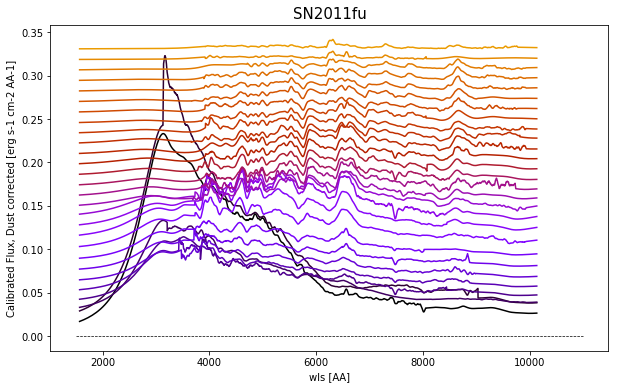

Choose one spec_file from this list:
['55880.50_spec_extended.txt', '55881.50_spec_extended.txt', '55882.50_spec_extended.txt', '55883.50_spec_extended.txt', '55892.50_spec_extended.txt', '55893.50_spec_extended.txt', '55896.50_spec_extended.txt', '55913.50_spec_extended.txt', '55914.50_spec_extended.txt', '55916.50_spec_extended.txt', '55941.50_spec_extended.txt', '55946.50_spec_extended.txt', '56048.50_spec_extended.txt']
55880.50_spec_extended.txt
self.spec_file 55880.50_spec_extended.txt
SCALE: 0.0174
SCALE: 0.0378
SCALE: 43018.0188
SCALE: 43018.8135
SCALE: 43019.6082
SCALE: 43020.4029
ITERATION 5 5
55881.50_spec_extended.txt
self.spec_file 55881.50_spec_extended.txt
SCALE: 0.0050
SCALE: 0.0510
SCALE: 0.1017
SCALE: 6.3959
SCALE: 6.3963
SCALE: 6.3967
ITERATION 5 5
55882.50_spec_extended.txt
self.spec_file 55882.50_spec_extended.txt
SCALE: 0.0053
SCALE: 0.0058
SCALE: 0.0426
SCALE: 13984.5180
SCALE: 13974.9300
SCALE: 13965.3793
ITERATION 5 5
55883.50_spec_extended.txt
self.spec_file 5

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


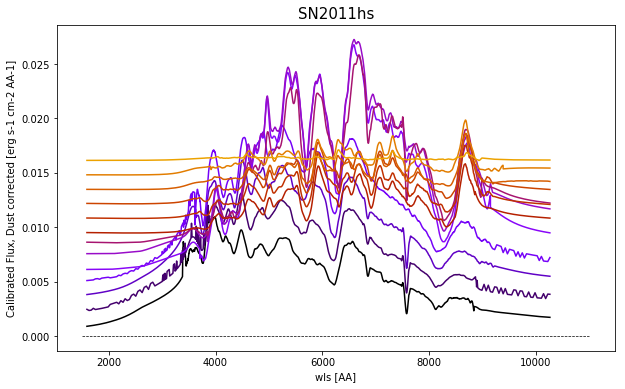

Choose one spec_file from this list:
['55866.00_spec_extended.txt', '55867.00_spec_extended.txt', '55876.00_spec_extended.txt', '55878.00_spec_extended.txt', '55881.00_spec_extended.txt', '55887.65_spec_extended.txt', '55916.00_spec_extended.txt', '55929.70_spec_extended.txt', '55949.41_spec_extended.txt', '55970.27_spec_extended.txt', '55986.81_spec_extended.txt', '55988.62_spec_extended.txt']
55866.00_spec_extended.txt
self.spec_file 55866.00_spec_extended.txt
SCALE: 0.1065
SCALE: 0.1065
SCALE: 0.1065
SCALE: 0.1065
SCALE: 0.1065
SCALE: 0.1066
ITERATION 5 5
55867.00_spec_extended.txt
self.spec_file 55867.00_spec_extended.txt
SCALE: 0.1955
SCALE: 0.6842
SCALE: 1.1777
SCALE: 1.4859
SCALE: 1.7440
SCALE: 1.9667
ITERATION 5 5
55876.00_spec_extended.txt
self.spec_file 55876.00_spec_extended.txt
SCALE: 0.0066
SCALE: 0.2641
SCALE: 0.2641
SCALE: 0.2641
SCALE: 0.2641
SCALE: 0.2641
ITERATION 5 5
55878.00_spec_extended.txt
self.spec_file 55878.00_spec_extended.txt
SCALE: 0.0447
SCALE: 0.0372
SCAL

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


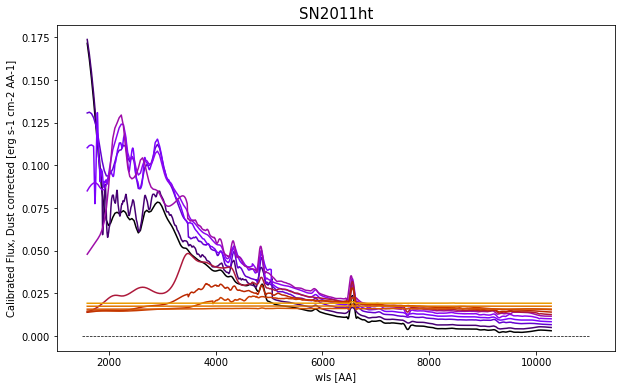

Choose one spec_file from this list:
['55936.14_spec_extended.txt', '55940.46_spec_extended.txt', '55941.71_spec_extended.txt', '55943.97_spec_extended.txt', '55944.53_spec_extended.txt', '55944.98_spec_extended.txt', '55946.06_spec_extended.txt', '55947.00_spec_extended.txt', '55948.48_spec_extended.txt', '55950.48_spec_extended.txt', '55951.46_spec_extended.txt', '55952.65_spec_extended.txt', '55953.53_spec_extended.txt', '55956.46_spec_extended.txt', '55957.42_spec_extended.txt', '55963.44_spec_extended.txt', '55968.60_spec_extended.txt', '55971.44_spec_extended.txt', '55975.52_spec_extended.txt', '55980.50_spec_extended.txt', '55983.49_spec_extended.txt', '55986.41_spec_extended.txt', '55998.59_spec_extended.txt', '55999.66_spec_extended.txt', '56002.37_spec_extended.txt', '56004.41_spec_extended.txt', '56012.51_spec_extended.txt', '56014.34_spec_extended.txt', '56016.33_spec_extended.txt', '56018.39_spec_extended.txt', '56030.31_spec_extended.txt', '56040.55_spec_extended.txt', '5

SCALE: 0.2997
SCALE: 0.2997
SCALE: 0.2997
SCALE: 0.2997
ITERATION 5 5


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


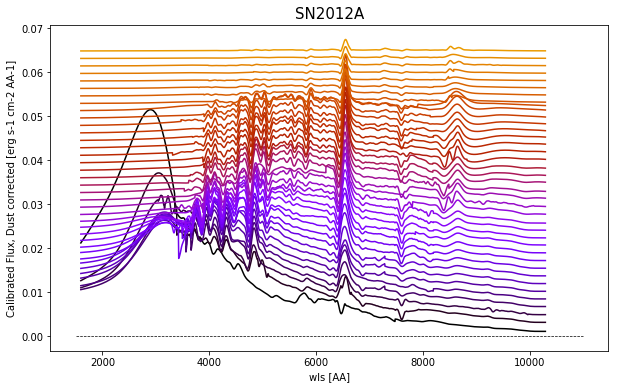

Choose one spec_file from this list:
['55971.06_spec_extended.txt', '55973.03_spec_extended.txt', '55975.01_spec_extended.txt', '55976.99_spec_extended.txt', '55977.97_spec_extended.txt', '55978.00_spec_extended.txt', '55979.95_spec_extended.txt', '55980.00_spec_extended.txt', '55982.92_spec_extended.txt', '55983.90_spec_extended.txt', '55989.83_spec_extended.txt', '56000.70_spec_extended.txt']
55971.06_spec_extended.txt
self.spec_file 55971.06_spec_extended.txt
SCALE: 0.0393
SCALE: 14698170.2477
SCALE: 14698170.1351
SCALE: 14698170.0225
SCALE: 14698169.9098
SCALE: 14698169.7971
ITERATION 5 5
55973.03_spec_extended.txt
self.spec_file 55973.03_spec_extended.txt
SCALE: 0.0273
SCALE: 443258.1754
SCALE: 443257.9535
SCALE: 443257.7315
SCALE: 443257.5096
SCALE: 443257.2877
ITERATION 5 5
55975.01_spec_extended.txt
self.spec_file 55975.01_spec_extended.txt
SCALE: 0.0074
SCALE: 2512047.6520
SCALE: 2512049.2810
SCALE: 2512050.9100
SCALE: 2512052.5391
SCALE: 2512054.1681
ITERATION 5 5
55976.99_sp

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


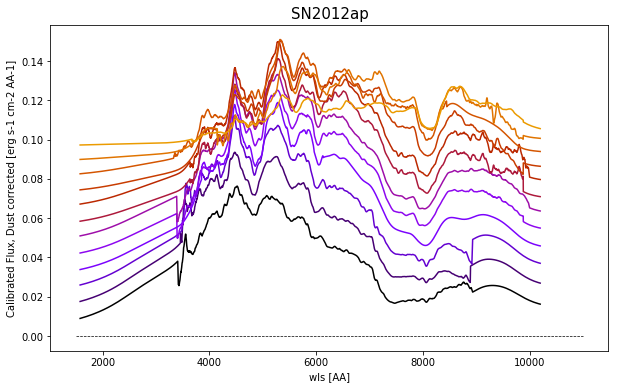

Choose one spec_file from this list:
['56001.52_spec_extended.txt', '56003.00_spec_extended.txt', '56013.00_spec_extended.txt', '56064.00_spec_extended.txt', '56094.36_spec_extended.txt']
56001.52_spec_extended.txt
self.spec_file 56001.52_spec_extended.txt
SCALE: 0.0136
SCALE: 0.0057
SCALE: 24255728.8753
SCALE: 24255728.5716
SCALE: 24255728.2675
SCALE: 24255727.9637
ITERATION 5 5
56003.00_spec_extended.txt
self.spec_file 56003.00_spec_extended.txt
SCALE: 0.1412
SCALE: 0.0312
SCALE: 0.0160
SCALE: 52019383.1606
SCALE: 52019382.9932
SCALE: 52019382.8264
ITERATION 5 5
56013.00_spec_extended.txt
self.spec_file 56013.00_spec_extended.txt
SCALE: 0.0050
SCALE: 0.0050
SCALE: 0.0056
SCALE: 0.0053
SCALE: 0.0054
SCALE: 0.0065
ITERATION 5 5
56064.00_spec_extended.txt
self.spec_file 56064.00_spec_extended.txt
SCALE: 0.0317
SCALE: 0.0051
SCALE: 0.0053
SCALE: 0.0071
SCALE: 0.0055
SCALE: 0.0084
ITERATION 5 5
56094.36_spec_extended.txt
self.spec_file 56094.36_spec_extended.txt
SCALE: 0.0051
SCALE: 0.005

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


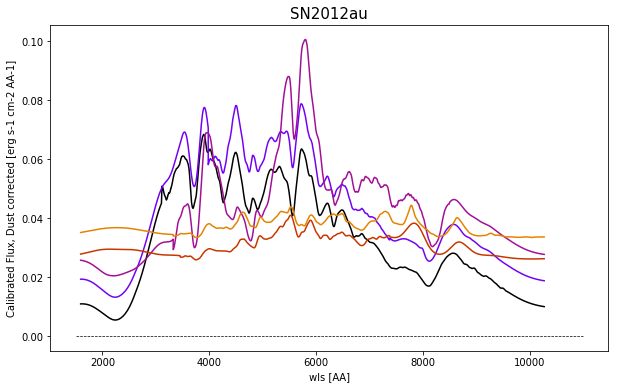

Choose one spec_file from this list:
['56003.00_spec_extended.txt', '56005.00_spec_extended.txt', '56006.86_spec_extended.txt', '56007.00_spec_extended.txt', '56007.93_spec_extended.txt', '56008.87_spec_extended.txt', '56009.00_spec_extended.txt', '56009.01_spec_extended.txt', '56010.88_spec_extended.txt', '56011.00_spec_extended.txt', '56011.98_spec_extended.txt', '56012.88_spec_extended.txt', '56013.88_spec_extended.txt', '56014.00_spec_extended.txt', '56015.93_spec_extended.txt', '56016.00_spec_extended.txt', '56017.00_spec_extended.txt', '56017.86_spec_extended.txt', '56019.00_spec_extended.txt', '56025.90_spec_extended.txt', '56027.74_spec_extended.txt', '56028.00_spec_extended.txt', '56031.12_spec_extended.txt', '56042.00_spec_extended.txt', '56048.06_spec_extended.txt', '56058.92_spec_extended.txt', '56064.86_spec_extended.txt', '56079.00_spec_extended.txt', '56094.00_spec_extended.txt', '56252.00_spec_extended.txt']
56003.00_spec_extended.txt
self.spec_file 56003.00_spec_extend

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


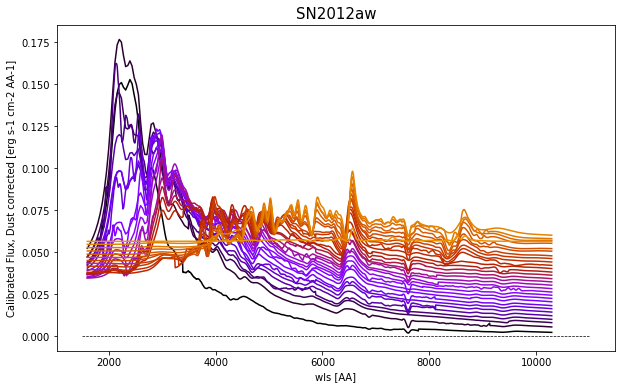

Choose one spec_file from this list:
['56347.21_spec_extended.txt', '56351.09_spec_extended.txt', '56352.08_spec_extended.txt', '56352.50_spec_extended.txt', '56353.51_spec_extended.txt', '56354.51_spec_extended.txt', '56355.09_spec_extended.txt', '56357.21_spec_extended.txt', '56368.45_spec_extended.txt', '56370.13_spec_extended.txt', '56382.08_spec_extended.txt', '56413.35_spec_extended.txt', '56415.35_spec_extended.txt', '56416.37_spec_extended.txt', '56417.08_spec_extended.txt', '56421.07_spec_extended.txt', '56427.36_spec_extended.txt', '56457.14_spec_extended.txt', '56484.35_spec_extended.txt', '56486.34_spec_extended.txt', '56508.21_spec_extended.txt', '56513.25_spec_extended.txt', '56522.25_spec_extended.txt']
56347.21_spec_extended.txt
self.spec_file 56347.21_spec_extended.txt
SCALE: 0.0058
SCALE: 0.0052
SCALE: 0.3000
SCALE: 0.3000
SCALE: 0.3000
SCALE: 0.0050
ITERATION 5 5
56351.09_spec_extended.txt
self.spec_file 56351.09_spec_extended.txt
SCALE: 0.0050
SCALE: 0.0060
SCALE: 0

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


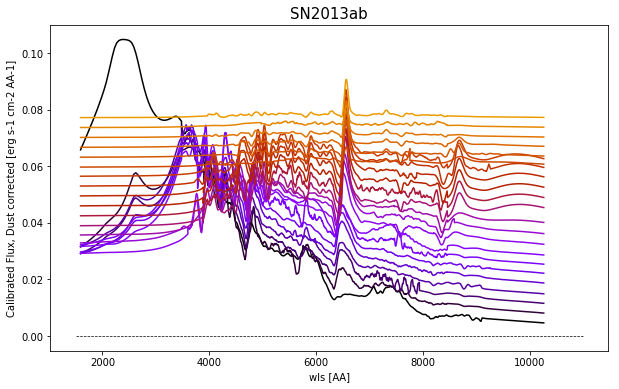

Choose one spec_file from this list:
['56373.50_spec_extended.txt', '56374.10_spec_extended.txt', '56375.30_spec_extended.txt', '56379.30_spec_extended.txt', '56381.20_spec_extended.txt', '56384.17_spec_extended.txt', '56388.16_spec_extended.txt', '56395.17_spec_extended.txt', '56398.10_spec_extended.txt', '56401.06_spec_extended.txt', '56404.10_spec_extended.txt', '56437.20_spec_extended.txt', '56454.50_spec_extended.txt', '56653.28_spec_extended.txt']
56373.50_spec_extended.txt
self.spec_file 56373.50_spec_extended.txt
SCALE: 0.0050
SCALE: 0.0057
SCALE: 0.0055
SCALE: 0.0066
SCALE: 0.0071
SCALE: 0.0059
ITERATION 5 5
56374.10_spec_extended.txt
self.spec_file 56374.10_spec_extended.txt
SCALE: 0.0063
SCALE: 0.5821
SCALE: 0.5821
SCALE: 0.5822
SCALE: 0.5822
SCALE: 0.5822
ITERATION 5 5
56375.30_spec_extended.txt
self.spec_file 56375.30_spec_extended.txt
SCALE: 0.1776
SCALE: 3.4362
SCALE: 3.4362
SCALE: 3.4362
SCALE: 3.4362
SCALE: 3.4362
ITERATION 5 5
56379.30_spec_extended.txt
self.spec_file

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


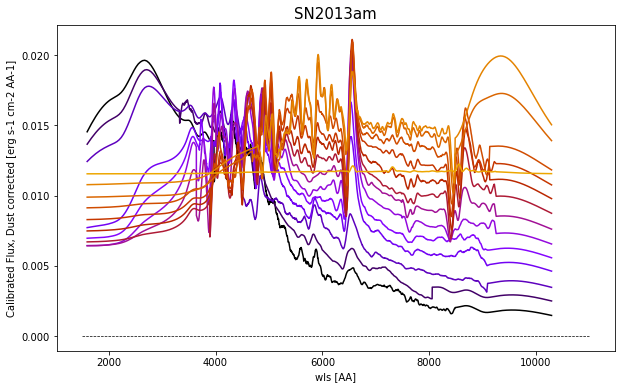

Choose one spec_file from this list:
['56406.00_spec_extended.txt', '56420.00_spec_extended.txt', '56438.00_spec_extended.txt', '56438.58_spec_extended.txt', '56438.59_spec_extended.txt', '56523.00_spec_extended.txt', '56564.03_spec_extended.txt']
56406.00_spec_extended.txt
self.spec_file 56406.00_spec_extended.txt
SCALE: 0.0050
SCALE: 0.9516
SCALE: 0.9516
SCALE: 0.9516
SCALE: 0.9516
SCALE: 0.9516
ITERATION 5 5
56420.00_spec_extended.txt
self.spec_file 56420.00_spec_extended.txt
SCALE: 0.0163
SCALE: 65943553.2420
SCALE: 65943553.9182
SCALE: 65943554.5910
SCALE: 65943555.2662
SCALE: 65943555.9406
ITERATION 5 5
56438.00_spec_extended.txt
self.spec_file 56438.00_spec_extended.txt
SCALE: 0.0113
SCALE: 15712149.5684
SCALE: 15712152.1537
SCALE: 15712154.7378
SCALE: 15712157.3230
SCALE: 15712159.9081
ITERATION 5 5
56438.58_spec_extended.txt
self.spec_file 56438.58_spec_extended.txt
SCALE: 0.0056
SCALE: 0.1605
SCALE: 3232107.0583
SCALE: 3232107.6387
SCALE: 3232108.2189
SCALE: 3232108.7993
ITER

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


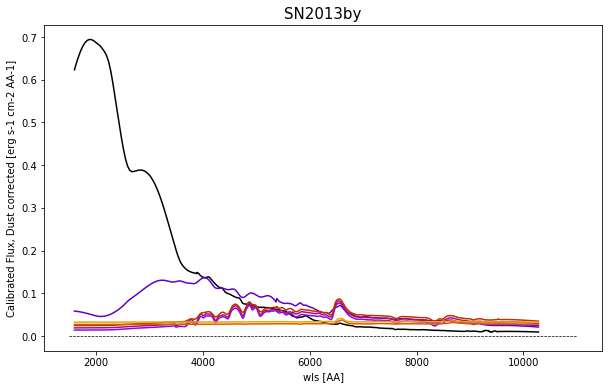

Choose one spec_file from this list:
['56459.50_spec_extended.txt', '56465.35_spec_extended.txt', '56466.50_spec_extended.txt', '56470.50_spec_extended.txt', '56474.50_spec_extended.txt', '56481.50_spec_extended.txt', '56484.50_spec_extended.txt', '56488.27_spec_extended.txt', '56506.24_spec_extended.txt', '56508.18_spec_extended.txt', '56512.18_spec_extended.txt', '56516.18_spec_extended.txt']
56459.50_spec_extended.txt
self.spec_file 56459.50_spec_extended.txt
SCALE: 0.0567
SCALE: 0.6394
SCALE: 0.6394
SCALE: 0.6394
SCALE: 0.6394
SCALE: 0.6394
ITERATION 5 5
56465.35_spec_extended.txt
self.spec_file 56465.35_spec_extended.txt
SCALE: 0.0051
SCALE: 0.1622
SCALE: 0.1622
SCALE: 0.1622
SCALE: 0.1622
SCALE: 0.1622
ITERATION 5 5
56466.50_spec_extended.txt
self.spec_file 56466.50_spec_extended.txt
SCALE: 0.0052
SCALE: 1.8342
SCALE: 1.8342
SCALE: 1.8342
SCALE: 1.8342
SCALE: 1.8342
ITERATION 5 5
56470.50_spec_extended.txt
self.spec_file 56470.50_spec_extended.txt
SCALE: 0.0118
SCALE: 47.3379
SCA

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


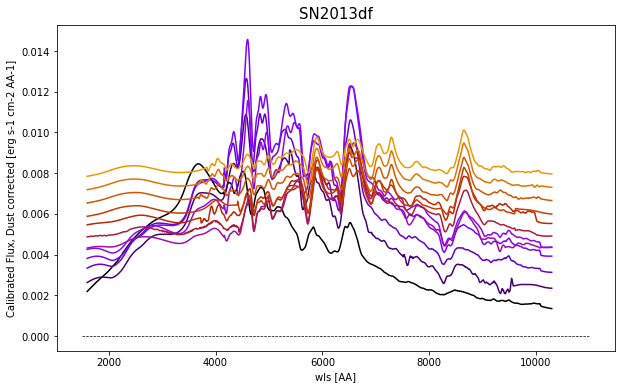

Choose one spec_file from this list:
['56500.50_spec_extended.txt', '56504.50_spec_extended.txt', '56505.50_spec_extended.txt', '56506.50_spec_extended.txt', '56507.50_spec_extended.txt', '56509.40_spec_extended.txt', '56511.50_spec_extended.txt', '56513.50_spec_extended.txt', '56516.50_spec_extended.txt', '56517.50_spec_extended.txt', '56521.50_spec_extended.txt', '56523.50_spec_extended.txt', '56526.50_spec_extended.txt', '56531.27_spec_extended.txt', '56534.50_spec_extended.txt', '56538.41_spec_extended.txt', '56539.50_spec_extended.txt', '56545.10_spec_extended.txt', '56548.25_spec_extended.txt', '56554.50_spec_extended.txt', '56564.28_spec_extended.txt', '56566.54_spec_extended.txt', '56570.33_spec_extended.txt', '56575.29_spec_extended.txt', '56589.50_spec_extended.txt', '56598.00_spec_extended.txt', '56604.00_spec_extended.txt', '56620.00_spec_extended.txt']
56500.50_spec_extended.txt
self.spec_file 56500.50_spec_extended.txt
SCALE: 0.0065
SCALE: 0.0063
SCALE: 0.0066
SCALE: 0.00

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


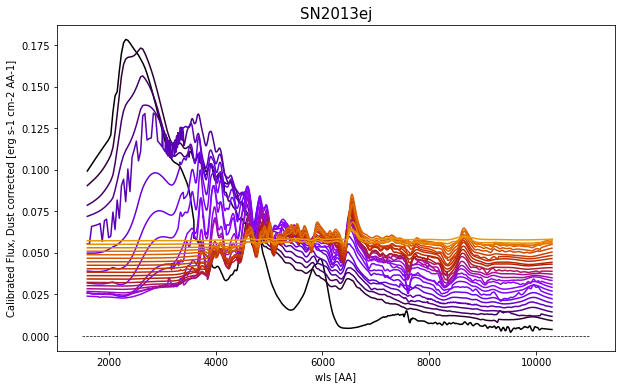

Choose one spec_file from this list:
['56571.04_spec_extended.txt', '56571.42_spec_extended.txt', '56571.49_spec_extended.txt', '56572.50_spec_extended.txt', '56573.17_spec_extended.txt', '56573.27_spec_extended.txt', '56573.52_spec_extended.txt', '56575.04_spec_extended.txt', '56576.20_spec_extended.txt', '56579.38_spec_extended.txt', '56582.05_spec_extended.txt', '56589.45_spec_extended.txt', '56591.34_spec_extended.txt', '56600.15_spec_extended.txt', '56600.16_spec_extended.txt', '56603.18_spec_extended.txt', '56608.11_spec_extended.txt', '56608.12_spec_extended.txt', '56610.45_spec_extended.txt', '56619.54_spec_extended.txt', '56622.20_spec_extended.txt', '56626.54_spec_extended.txt', '56653.54_spec_extended.txt']
56571.04_spec_extended.txt
self.spec_file 56571.04_spec_extended.txt
SCALE: 0.7800
SCALE: 0.7800
SCALE: 0.7800
SCALE: 0.7800
SCALE: 0.7800
SCALE: 0.7800
ITERATION 5 5
56571.42_spec_extended.txt
self.spec_file 56571.42_spec_extended.txt
SCALE: 1.8295
SCALE: 1.8295
SCALE: 1

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


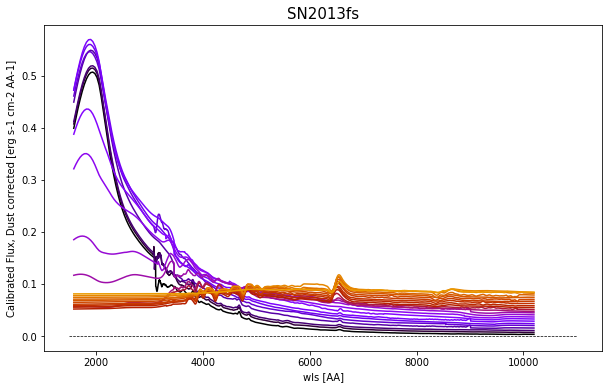

Choose one spec_file from this list:
['56605.06_spec_extended.txt', '56606.06_spec_extended.txt', '56607.05_spec_extended.txt', '56617.01_spec_extended.txt', '56624.00_spec_extended.txt', '56624.98_spec_extended.txt', '56631.95_spec_extended.txt', '56632.94_spec_extended.txt', '56635.93_spec_extended.txt', '56638.92_spec_extended.txt', '56649.87_spec_extended.txt', '56652.86_spec_extended.txt', '56653.85_spec_extended.txt', '56656.84_spec_extended.txt', '56659.83_spec_extended.txt', '56662.82_spec_extended.txt', '56663.81_spec_extended.txt', '56665.80_spec_extended.txt']
56605.06_spec_extended.txt
self.spec_file 56605.06_spec_extended.txt
SCALE: 0.0051
SCALE: 0.0592
SCALE: 0.0955
SCALE: 0.1225
SCALE: 0.1427
SCALE: 0.1582
ITERATION 5 5
56606.06_spec_extended.txt
self.spec_file 56606.06_spec_extended.txt
SCALE: 0.0322
SCALE: 3.7966
SCALE: 3.7966
SCALE: 3.7966
SCALE: 3.7966
SCALE: 3.7966
ITERATION 5 5
56607.05_spec_extended.txt
self.spec_file 56607.05_spec_extended.txt
SCALE: 0.0117
SCALE

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


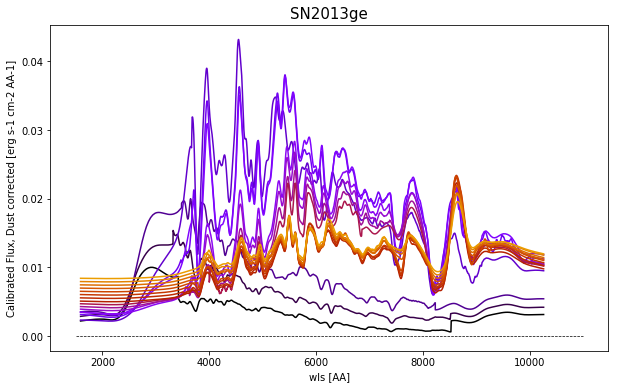

Choose one spec_file from this list:
['56671.13_spec_extended.txt', '56672.41_spec_extended.txt', '56678.42_spec_extended.txt', '56682.42_spec_extended.txt', '56686.21_spec_extended.txt', '56694.44_spec_extended.txt', '56705.53_spec_extended.txt', '56707.52_spec_extended.txt', '56714.19_spec_extended.txt', '56722.39_spec_extended.txt', '56726.08_spec_extended.txt', '56733.30_spec_extended.txt', '56746.06_spec_extended.txt', '56754.49_spec_extended.txt', '56772.43_spec_extended.txt', '56788.41_spec_extended.txt', '56806.40_spec_extended.txt']
56671.13_spec_extended.txt
self.spec_file 56671.13_spec_extended.txt
SCALE: 0.2084
SCALE: 29112.2167
SCALE: 29113.0975
SCALE: 29113.9785
SCALE: 29114.8595
SCALE: 29115.7406
ITERATION 5 5
56672.41_spec_extended.txt
self.spec_file 56672.41_spec_extended.txt
SCALE: 0.5154
SCALE: 1.8113
SCALE: 1.8113
SCALE: 1.8113
SCALE: 1.8113
SCALE: 1.8113
ITERATION 5 5
56678.42_spec_extended.txt
self.spec_file 56678.42_spec_extended.txt
SCALE: 0.0087
SCALE: 0.2441
S

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


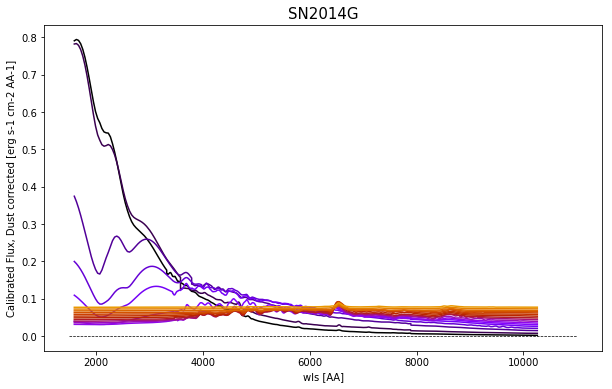

Choose one spec_file from this list:
['57407.10_spec_extended.txt', '57408.10_spec_extended.txt', '57410.00_spec_extended.txt', '57412.00_spec_extended.txt', '57414.10_spec_extended.txt', '57415.10_spec_extended.txt', '57418.10_spec_extended.txt', '57420.00_spec_extended.txt', '57421.10_spec_extended.txt', '57424.10_spec_extended.txt', '57428.10_spec_extended.txt', '57431.00_spec_extended.txt', '57434.00_spec_extended.txt', '57434.10_spec_extended.txt', '57436.00_spec_extended.txt', '57440.10_spec_extended.txt', '57446.10_spec_extended.txt', '57453.10_spec_extended.txt', '57458.00_spec_extended.txt', '57459.10_spec_extended.txt', '57465.10_spec_extended.txt', '57468.10_spec_extended.txt', '57474.00_spec_extended.txt', '57482.00_spec_extended.txt', '57485.10_spec_extended.txt', '57491.10_spec_extended.txt', '57495.00_spec_extended.txt', '57495.69_spec_extended.txt', '57504.00_spec_extended.txt', '57507.10_spec_extended.txt', '57510.00_spec_extended.txt', '57529.10_spec_extended.txt', '5

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


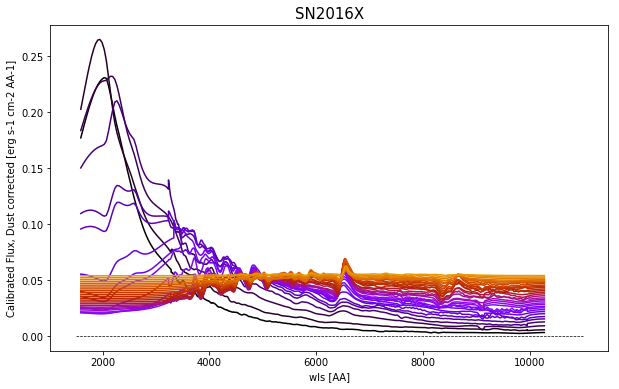

Choose one spec_file from this list:
['57470.49_spec_extended.txt', '57471.42_spec_extended.txt', '57472.27_spec_extended.txt', '57475.35_spec_extended.txt', '57480.42_spec_extended.txt', '57481.53_spec_extended.txt', '57487.41_spec_extended.txt', '57491.58_spec_extended.txt', '57492.42_spec_extended.txt', '57498.37_spec_extended.txt', '57502.26_spec_extended.txt', '57507.28_spec_extended.txt', '57511.31_spec_extended.txt', '57526.25_spec_extended.txt', '57550.28_spec_extended.txt']
57470.49_spec_extended.txt
self.spec_file 57470.49_spec_extended.txt
SCALE: 0.0057
SCALE: 0.2430
SCALE: 1.7249
SCALE: 4671691.4255
SCALE: 4671696.1052
SCALE: 4671700.7849
ITERATION 5 5
57471.42_spec_extended.txt
self.spec_file 57471.42_spec_extended.txt
SCALE: 0.0062
SCALE: 4.2729
SCALE: 4.2729
SCALE: 4.2729
SCALE: 4.2729
SCALE: 4.2729
ITERATION 5 5
57472.27_spec_extended.txt
self.spec_file 57472.27_spec_extended.txt
SCALE: 0.0051
SCALE: 27411.0916
SCALE: 27414.0052
SCALE: 27416.9191
SCALE: 27419.8331
SCALE

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


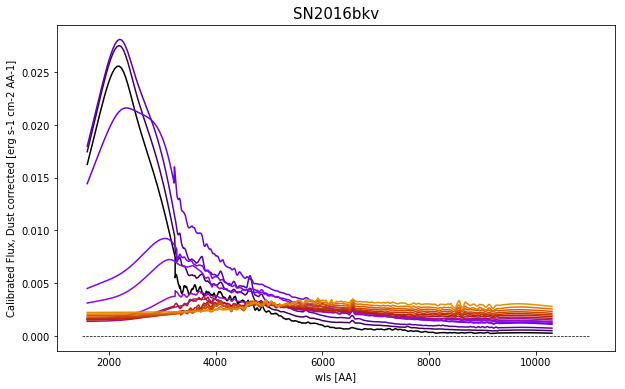

Choose one spec_file from this list:
['57652.89_spec_extended.txt', '57653.16_spec_extended.txt', '57653.20_spec_extended.txt', '57654.17_spec_extended.txt', '57654.18_spec_extended.txt', '57655.13_spec_extended.txt', '57655.14_spec_extended.txt', '57656.19_spec_extended.txt', '57658.52_spec_extended.txt', '57660.03_spec_extended.txt', '57660.12_spec_extended.txt', '57661.11_spec_extended.txt', '57664.11_spec_extended.txt', '57666.29_spec_extended.txt', '57670.08_spec_extended.txt', '57670.39_spec_extended.txt', '57685.99_spec_extended.txt']
57652.89_spec_extended.txt
self.spec_file 57652.89_spec_extended.txt
SCALE: 0.0063
SCALE: 0.0050
SCALE: 0.0055
SCALE: 0.0073
SCALE: 0.0058
SCALE: 0.0091
ITERATION 5 5
57653.16_spec_extended.txt
self.spec_file 57653.16_spec_extended.txt
SCALE: 0.0063
SCALE: 0.0088
SCALE: 0.0075
SCALE: 0.0059
SCALE: 0.0064
SCALE: 0.0056
ITERATION 5 5
57653.20_spec_extended.txt
self.spec_file 57653.20_spec_extended.txt
SCALE: 0.0059
SCALE: 0.0056
SCALE: 0.0056
SCALE: 

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


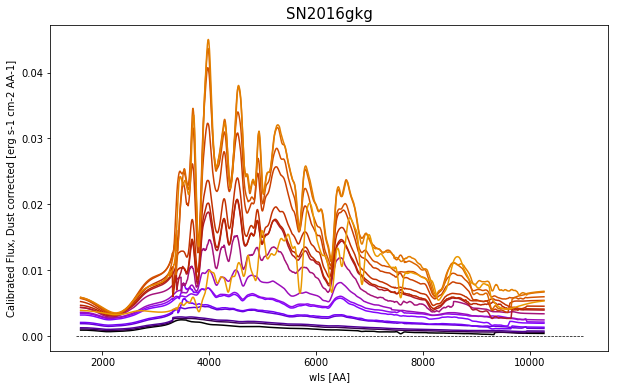

Choose one spec_file from this list:
['56460.00_spec_extended.txt', '56460.91_spec_extended.txt', '56461.00_spec_extended.txt', '56462.34_spec_extended.txt', '56463.00_spec_extended.txt', '56465.00_spec_extended.txt', '56467.00_spec_extended.txt', '56468.00_spec_extended.txt', '56469.00_spec_extended.txt', '56470.16_spec_extended.txt', '56471.00_spec_extended.txt', '56474.00_spec_extended.txt', '56474.10_spec_extended.txt', '56477.00_spec_extended.txt', '56478.00_spec_extended.txt', '56482.34_spec_extended.txt', '56484.00_spec_extended.txt', '56494.93_spec_extended.txt', '56496.00_spec_extended.txt', '56506.43_spec_extended.txt', '56508.00_spec_extended.txt', '56510.00_spec_extended.txt', '56512.42_spec_extended.txt', '56539.00_spec_extended.txt', '56544.26_spec_extended.txt']
56460.00_spec_extended.txt
self.spec_file 56460.00_spec_extended.txt
SCALE: 0.0056
SCALE: 0.0056
SCALE: 0.0076
SCALE: 0.0052
SCALE: 0.0057
SCALE: 0.0050
ITERATION 5 5
56460.91_spec_extended.txt
self.spec_file 564

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


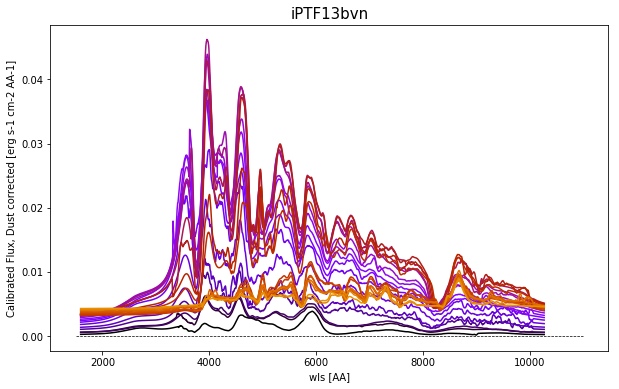

I cant mangle a spectrum if I theres no fitted LC yet
Choose one spec_file from this list:


FileNotFoundError: [Errno 2] No such file or directory: '/Users/mariavincenzi/PhD/pycoco_2/data//results_template/SN2013bynouv/TwoDextended_spectra/'

In [14]:
for snname,type_ in sn_type_lista[:]:
    if 1.>0.:#if snname in SN_lista:
        new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=snname, twodim=True,\
                            spec_file=None, verbose=True)
        for a in new_spec.get_spec_list()[:]:
            try:
                print (a)
                new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=new_spec.snname, twodim=True,\
                                    spec_file=a, verbose=False)
                new_spec.load_extended_spec()
                result = new_spec.mangle_iteration_function()
                new_spec.save_FINAL_spectrum()
                
            except:
                pass
        color=cycle(plt.cm.gnuplot(np.linspace(0,1,len(new_spec.get_spec_list())*1.2)))
        fig= plt.figure(1, figsize=(10,6))
        plt.title(new_spec.snname, fontsize=15)
        mean=1.; a=0
        for l in new_spec.get_spec_list()[:]:
            new_spec.create_FINALspec_folder()
            sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
            plt.plot(sp[:,0], sp[:,1]+mean*a, lw=1.5,color=next(color))
            if mean==1.:
                mean = np.median(sp[:,1])*0.2
            a=a+1
            
        plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
        plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
        plt.xlabel('wls [AA]')
        fig.savefig(new_spec.FINALspec_path+'Final_Spec.png', bbox_inches='tight')
        plt.show()
        plt.close()

In [48]:
sn_type_lista = [('ASASSN14jb', 'II'),
 ('ASASSN15oz', 'II'),
 ('SN1987A', 'II'),
 ('SN1993J', 'IIb'),
 ('SN1994I', 'Ic'),
 ('SN1998bw', 'Ic-BL'),
 ('SN1999dn', 'Ib'),
 ('SN1999em', 'II'),
 ('SN2002ap', 'Ic-BL'),
 ('SN2004aw', 'Ic'),
 ('SN2004et', 'II'),
 ('SN2004fe', 'Ic'),
 ('SN2004gq', 'Ib'),
 ('SN2004gt', 'Ic'),
 ('SN2004gv', 'Ib'),
 ('SN2005bf', 'Ib'),
 ('SN2005cs', 'II'),
 ('SN2005hg', 'Ib'),
 ('SN2006T', 'IIb'),
 ('SN2006aa', 'IIn'),
 ('SN2006aj', 'Ic-BL'),
 ('SN2006ep', 'Ib'),
 ('SN2007Y', 'Ib'),
 ('SN2007gr', 'Ic'),
 ('SN2007od', 'II'),
 ('SN2007pk', 'IIn'),
 ('SN2007ru', 'Ic-BL'),
 ('SN2007uy', 'Ib'),
 ('SN2008D', 'Ib'),
 ('SN2008aq', 'IIb'),
 ('SN2008ax', 'IIb'),
 ('SN2008bj', 'II'),
 ('SN2008bo', 'IIb'),
 ('SN2008fq', 'IIn'),
 ('SN2008in', 'II'),
 ('SN2009N', 'II'),
 ('SN2009bb', 'Ic-BL'),
 ('SN2009bw', 'II'),
 ('SN2009dd', 'II'),
 ('SN2009ib', 'II'),
 ('SN2009ip', 'IIn'),
 ('SN2009iz', 'Ib'),
 ('SN2009jf', 'Ib'),
 ('SN2009kr', 'II'),
 ('SN2010al', 'IIn'),
 ('SN2011bm', 'Ic'),
 ('SN2011dh', 'IIb'),
 ('SN2011ei', 'IIb'),
 ('SN2011fu', 'IIb'),
 ('SN2011hs', 'IIb'),
 ('SN2011ht', 'IIn'),
 ('SN2012A', 'II'),
 ('SN2012ap', 'Ic-BL'),
 ('SN2012au', 'Ib'),
 ('SN2012aw', 'II'),
 ('SN2013ab', 'II'),
 ('SN2013am', 'II'),
 ('SN2013by', 'II'),
 ('SN2013df', 'IIb'),
 ('SN2013ej', 'II'),
 ('SN2013fs', 'II'),
 ('SN2013ge', 'Ic'),
 ('SN2014G', 'II'),
 ('SN2016X', 'II'),
 ('SN2016bkv', 'II'),
 ('SN2016gkg', 'IIb'),
 ('iPTF13bvn', 'Ib'),
 ('SN2013bynouv', 'II')]

Choose one spec_file from this list:
['56950.15_spec_extended.txt', '56951.19_spec_extended.txt', '56952.16_spec_extended.txt', '56953.17_spec_extended.txt', '56954.17_spec_extended.txt', '56955.18_spec_extended.txt', '56957.13_spec_extended.txt', '56981.09_spec_extended.txt', '57011.08_spec_extended.txt', '57026.55_spec_extended.txt']
self.spec_file 56946.15_spec_extended_FL.txt
ITERATION 1 1


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/george/kernels.py:95: RuntimeWarning: divide by zero encountered in log
  log_constant = np.log(float(b)/self.ndim)


self.spec_file 56946.35_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56946.65_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56948.15_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56959.13_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56961.12_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56963.12_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56965.12_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56967.11_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56969.11_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56971.11_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56973.10_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56975.10_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56977.10_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56979.09_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56983.09_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56985.09_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 56987.09_spec_extended_FL.txt
ITERATION 5

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


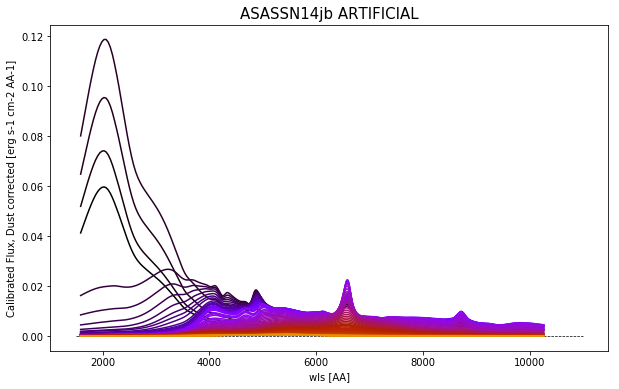

In [11]:
# SN 2013ab had some problems!!!!!

for sn,type_ in sn_type_lista[:]:
    if sn in ['ASASSN14jb']:#if snname in SN_lista:
        new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=sn, twodim=True,\
                                spec_file=None, verbose=True)
        for f in new_spec.get_FLAGGED_spec_list():
            try:
                new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=sn, twodim=True,\
                            spec_file=f, verbose=True)
        
                new_spec.load_extended_spec()
                result = new_spec.mangle_iteration_function()
                new_spec.save_FINAL_spectrum()
            except:
                pass
        new_spec.create_FINALspec_folder()
        color=cycle(plt.cm.gnuplot(np.linspace(0,1,len(new_spec.get_FLAGGED_spec_list())*1.2)))
        fig= plt.figure(1, figsize=(10,6))
        plt.title(sn+' ARTIFICIAL', fontsize=15)
        mean=1.; a=0
        for l in new_spec.get_FLAGGED_spec_list()[:]:
            sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
            plt.plot(sp[:,0], sp[:,1]+mean*a, lw=1.5,color=next(color))
            if mean==1.:
                mean = np.median(sp[:,1])*0.2
            
        plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
        plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
        plt.xlabel('wls [AA]')
        fig.savefig(new_spec.FINALspec_path+'Final_Spec_FL.png', bbox_inches='tight')
        plt.show()
        plt.close()

In [67]:
check = ['SN2008aq', 'SN2008in', 'SN2008bj', 'SN2008D', 'SN2009bw',
          'SN2009dd', 'SN2011dh', 'SN2011ei','SN2013ge', 'SN2011ht',
          'SN2011fu', 'SN2011hs', 'SN2012A', 'SN2012au', 'SN2012aw',
          'SN2013by', 'SN2013fs', 'SN2014G', 'SN2016gkg','SN2016X', 'SN2008ax', 
           'SN2008fq', 'SN2009bb', 'SN2009ib', 'SN2009jf', 'SN2009kr', 'SN2013am', 'SN2013ab', 'SN2013df']


check = ['iPTF13bvn']
#['SN2009bb', 'SN2009iz', 'SN2011dh','SN2011ei','SN2011hs','SN2012au','SN2013df','SN2013ge']

#['SN2005hg', 'SN2004gt', 'SN2004gq','SN2004aw','SN2004fe','SN1999dn']

In [122]:
check=['SN2011dh']

## REMANGLE true and artifical FOR ALL SNe

In [123]:
for snname,type_ in sn_type_lista:
    if snname in check:
        mangledspec_directory = DATALC_PATH+'/results_template/%s/RE_mangled_spectra_%s/'%(snname, '2dim')
        os.system('rm -rf %s'%mangledspec_directory)
        os.makedirs(mangledspec_directory)

        FINAL_directory = DATALC_PATH+'/results_template/%s/FINAL_spectra_%s/'%(snname, '2dim')
        os.system('rm -rf %s'%FINAL_directory)
        os.makedirs(FINAL_directory)

Choose one spec_file from this list:
['55715.33_spec_extended.txt', '55716.00_spec_extended.txt', '55717.92_spec_extended.txt', '55718.90_spec_extended.txt', '55719.00_spec_extended.txt', '55720.95_spec_extended.txt', '55721.38_spec_extended.txt', '55722.06_spec_extended.txt', '55724.88_spec_extended.txt', '55729.95_spec_extended.txt', '55732.92_spec_extended.txt', '55737.99_spec_extended.txt', '55741.00_spec_extended.txt', '55742.23_spec_extended.txt', '55747.90_spec_extended.txt', '55748.24_spec_extended.txt', '55752.91_spec_extended.txt', '55756.89_spec_extended.txt', '55760.88_spec_extended.txt', '55761.89_spec_extended.txt', '55764.90_spec_extended.txt', '55770.91_spec_extended.txt', '55778.18_spec_extended.txt', '55779.89_spec_extended.txt', '55794.89_spec_extended.txt', '55801.87_spec_extended.txt', '55803.86_spec_extended.txt', '55811.86_spec_extended.txt', '55820.83_spec_extended.txt', '55827.85_spec_extended.txt', '55864.15_spec_extended.txt', '55867.21_spec_extended.txt', '5

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


self.spec_file 55712.55_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55712.91_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55713.26_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55713.62_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55713.98_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55714.34_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55714.69_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55715.05_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55715.41_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55715.76_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55716.12_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55716.48_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55716.84_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55717.19_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55717.55_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55726.57_spec_extended_FL.txt
ITERATION 5 5
self.spec_file 55728.26_spec_extended_FL.txt
ITERATION 5

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:46: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


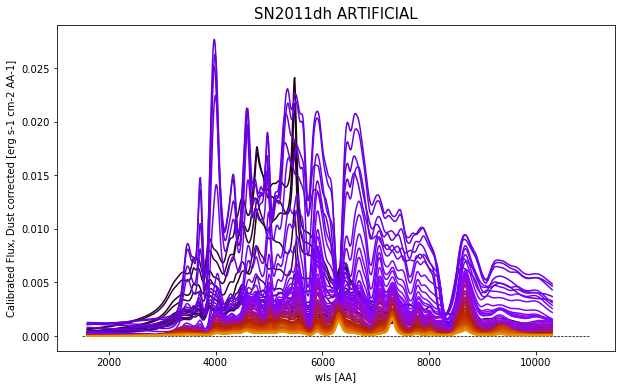

In [124]:
for sn,type_ in sn_type_lista[:]:
    if sn in check:
        new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=sn, twodim=True,\
                            spec_file=None, verbose=True)
        for a in new_spec.get_spec_list()[:]:
            try:
                print (a)
                new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=new_spec.snname, twodim=True,\
                                    spec_file=a, verbose=False)
                new_spec.load_extended_spec()
                result = new_spec.mangle_iteration_function()
                new_spec.save_FINAL_spectrum()
                
            except:
                pass
        color=cycle(plt.cm.gnuplot(np.linspace(0,1,len(new_spec.get_spec_list())*1.2)))
        fig= plt.figure(1, figsize=(10,6))
        plt.title(new_spec.snname, fontsize=15)
        mean=1.; a=0
        for l in new_spec.get_spec_list()[:]:
            try:
                new_spec.create_FINALspec_folder()
                sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
                plt.plot(sp[:,0], sp[:,1]+mean*a, lw=1.5,color=next(color))
                if mean==1.:
                    mean = np.median(sp[:,1])*0.2
                a=a+1
            except:
                pass
            
        plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
        plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
        plt.xlabel('wls [AA]')
        fig.savefig(new_spec.FINALspec_path+'Final_Spec.png', bbox_inches='tight')
        plt.show()
        plt.close()    

        for f in new_spec.get_FLAGGED_spec_list():
            try:
                new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=sn, twodim=True,\
                            spec_file=f, verbose=True)
        
                new_spec.load_extended_spec()
                result = new_spec.mangle_iteration_function()
                new_spec.save_FINAL_spectrum()
            except:
                pass
        new_spec.create_FINALspec_folder()
        color=cycle(plt.cm.gnuplot(np.linspace(0,1,len(new_spec.get_FLAGGED_spec_list())*1.2)))
        fig= plt.figure(1, figsize=(10,6))
        plt.title(sn+' ARTIFICIAL', fontsize=15)
        mean=1.; a=0
        for l in new_spec.get_FLAGGED_spec_list()[:]:
            try:
                sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
                plt.plot(sp[:,0], sp[:,1]+mean*a, lw=1.5,color=next(color))
                if mean==1.:
                    mean = np.median(sp[:,1])*0.2
            except:
                pass
            
        plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
        plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
        plt.xlabel('wls [AA]')
        fig.savefig(new_spec.FINALspec_path+'Final_Spec_FL.png', bbox_inches='tight')
        plt.show()
        plt.close()

In [87]:
#hl = pd.DataFrame(np.genfromtxt('./../../PS1.HOSTLIB', skip_header=1, names=True, dtype=None))

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':
